# Аналитика ДТП по предоставленным данным

Заказчиком (Оунером задачи) выступает проект «Карта ДТП» https://dtp-stat.ru/ — некоммерческий проект, посвященный проблеме дорожно-транспортных происшествий в России. Это платформа сбора данных о ДТП, бесплатный и открытый сервис аналитики ДТП.

**Цель проекта** - провести глубокий анализ данных, сформулировать и проверить гипотезы, опираясь на доступные признаки.

**Задачи**
* Провести исследовательский анализ данных о ДТП за 2025 год.
* Сформулировать и проверить не менее трех гипотез, основываясь на имеющихся признаках.
* Провести анализ ДТП по всем датасетам, представленным на сайте.
* Построить дашборд используя любой удобный инструмент, с учетом того, что дашборд может быть опубликован

**Декомпозиция работы:**
* Загрузка датасета и знакомство с данными
* Предобработка данных
* Исследовательский анализ данных
* Проверка гипотез
* Общие выводы
* Подготовка дашборда

## 1. Загрузка датасета и знакомство с данными

In [1]:
# Установка библиотеки для корреляционного анализа
!pip install phik

In [2]:
import os
import pandas as pd
import numpy as np
# import gc
from phik import phik_matrix

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# Настройка отображения Jupiter
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)  # Отображать все столбцы
pd.set_option('display.width', None)  # Автоматическая ширина
pd.set_option('display.max_colwidth', None)  # Отображать полную ширину столбцов
pd.set_option('display.float_format', '{:.2f}'.format)

**Для скачивания датасетов с сайта - необходимо использовать скрипт из ноутбука "DataLoader.ipynb"**

Загрузим данные:

In [3]:
all_records = []

download_dir = 'geojson_files'

# перебираем все .geojson в папке
for filename in os.listdir(download_dir):
    if filename.endswith(".geojson"):
        path = os.path.join(download_dir, filename)
        try:
            with open(path, encoding="utf-8") as f:
                data = json.load(f)
            accidents = data["features"]

            records = []
            for feature in accidents:
                props = feature["properties"].copy()
                props["geometry"] = feature["geometry"]
                records.append(props)

            all_records.extend(records)
            print(f"Загружено {len(records)} строк из {filename}")

        except Exception as e:
            print(f"Ошибка при обработке {filename}: {e}")

# объединяем в один датафрейм
data = pd.DataFrame(all_records)

print(f"Итого строк во всех файлах: {len(data)}")

# Удалим переменную all_records:
del all_records

Загружено 10307 строк из novgorodskaia-oblast.geojson
Загружено 27892 строк из tiumenskaia-oblast.geojson
Загружено 5855 строк из sevastopol.geojson
Загружено 41694 строк из cheliabinskaia-oblast.geojson
Загружено 7015 строк из respublika-kareliia.geojson
Загружено 25787 строк из volgogradskaia-oblast.geojson
Загружено 20977 строк из vladimirskaia-oblast.geojson
Загружено 2323 строк из magadanskaia-oblast.geojson
Загружено 10181 строк из kurganskaia-oblast.geojson
Загружено 29859 строк из sverdlovskaia-oblast.geojson
Загружено 16533 строк из respublika-dagestan.geojson
Загружено 5274 строк из respublika-tyva.geojson
Загружено 2589 строк из chechenskaia-respublika.geojson
Загружено 12534 строк из arkhangelskaia-oblast.geojson
Загружено 5254 строк из respublika-kalmykiia.geojson
Загружено 13438 строк из tambovskaia-oblast.geojson
Загружено 28453 строк из omskaia-oblast.geojson
Загружено 6748 строк из kabardino-balkarskaia-respublika.geojson
Загружено 4274 строк из iamalo-nenetskii-avtono

Откроем датасет и посмотрим на данные:

In [4]:
data.head()

,id,tags,light,point,nearby,region,scheme,address,weather,category,datetime,severity,vehicles,dead_count,participants,injured_count,parent_region,road_conditions,participants_count,participant_categories,geometry
0,1504730,[Дорожно-транспортные происшествия],Светлое время суток,"{'lat': 58.332904, 'long': 30.415138}",[],Шимский район,200,"Медведь-Батецкий, 7 км",[Ясно],Столкновение,2025-05-01 12:55:00,С погибшими,"[{'year': 2012, 'brand': 'KIA', 'color': 'Серый', 'model': 'Venga', 'category': 'В-класс (малый) до 3,9 м', 'participants': [{'role': 'Водитель', 'gender': 'Женский', 'violations': ['Выезд на полосу встречного движения'], 'health_status': 'Не пострадал', 'years_of_driving_experience': 4}, {'role': 'Пассажир', 'gender': 'Женский', 'violations': [], 'health_status': 'Не пострадал', 'years_of_driving_experience': None}]}, {'year': 2013, 'brand': 'Прочие марки мотоциклов', 'color': 'Красный', 'model': 'Прочие марки мотоциклов', 'category': 'Мопеды с двигателем внутреннего сгорания менее 50 см. куб.', 'participants': [{'role': 'Водитель', 'gender': 'Мужской', 'violations': ['Управление ТС лицом, не имеющим права на управление ТС'], 'health_status': 'Скончался на месте ДТП до приезда скорой медицинской помощи', 'years_of_driving_experience': None}]}]",1,[],0,Новгородская область,[Сухое],3,"[Все участники, Мотоциклисты]","{'type': 'Point', 'coordinates': [30.415138, 58.332904]}"
1,156565,[Дорожно-транспортные происшествия],Светлое время суток,"{'lat': None, 'long': None}",[],Шимский район,600,"Батецкий-Медведь, 10 км",[Ясно],Опрокидывание,2015-06-11 16:10:00,Легкий,"[{'year': 2011, 'brand': 'KIA', 'color': 'Синий', 'model': 'Rio', 'category': 'D-класс (средний) до 4,6 м', 'participants': [{'role': 'Водитель', 'gender': 'Женский', 'violations': ['Другие нарушения ПДД водителем'], 'health_status': 'Раненый, находящийся (находившийся) на амбулаторном лечении, либо которому по характеру полученных травм обозначена необходимость амбулаторного лечения (вне зависимости от его фактического прохождения)', 'years_of_driving_experience': 10}]}]",0,[],1,Новгородская область,[Сухое],1,[Все участники],"{'type': 'Point', 'coordinates': [None, None]}"
2,156274,[Дорожно-транспортные происшествия],"В темное время суток, освещение включено","{'lat': 58.295429, 'long': 30.494614}","[Жилые дома индивидуальной застройки, Нерегулируемый пешеходный переход, Остановка общественного транспорта, Нерегулируемый перекрёсток]",Шимский район,840,"д Старый Медведь, Медведь-Батецкий, 1 км",[Ясно],Наезд на пешехода,2022-10-07 20:30:00,Тяжёлый,"[{'year': 2009, 'brand': 'ВАЗ', 'color': 'Черный', 'model': 'Priora', 'category': 'В-класс (малый) до 3,9 м', 'participants': [{'role': 'Водитель', 'gender': 'Мужской', 'violations': ['Оставление места ДТП', 'Несоответствие скорости конкретным условиям движения'], 'health_status': 'Не пострадал', 'years_of_driving_experience': 13}]}]",0,"[{'role': 'Пешеход', 'gender': 'Мужской', 'violations': [], 'health_status': 'Раненый, находящийся (находившийся) на стационарном лечении'}]",1,Новгородская область,[Сухое],2,"[Все участники, Пешеходы]","{'type': 'Point', 'coordinates': [30.494614, 58.295429]}"
3,156238,[Дорожно-транспортные происшествия],"В темное время суток, освещение включено","{'lat': 58.210136, 'long': 30.721529}","[Административные здания, Многоквартирные жилые дома, Нерегулируемый пешеходный переход]",Шимский район,740,"рп Шимск, ул Новгородская, 6",[Пасмурно],Наезд на пешехода,2022-12-06 17:05:00,Легкий,"[{'year': 2009, 'brand': 'CHEVROLET', 'color': 'Синий', 'model': 'Cruze', 'category': 'D-класс (средний) до 4,6 м', 'participants': [{'role': 'Водитель', 'gender': 'Мужской', 'violations': ['Непредоставление преимущества в движении пешеходу', 'Другие нарушения ПДД водителем'], 'health_status': 'Не пострадал', 'years_of_driving_experience': 25}]}]",0,"[{'role': 'Пешеход', 'gender': 'Женский', 'violations': [], 'health_status': 'Раненый, находящийся (находившийся) на амбулаторном лечении, либо в условиях дневно

Посмотрим общую информацию о датасете:

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440070 entries, 0 to 1440069
Data columns (total 21 columns):
 #   Column                  Non-Null Count    Dtype 
---  ------                  --------------    ----- 
 0   id                      1440070 non-null  int64 
 1   tags                    1440070 non-null  object
 2   light                   1440070 non-null  object
 3   point                   1440070 non-null  object
 4   nearby                  1440070 non-null  object
 5   region                  1440070 non-null  object
 6   scheme                  1361453 non-null  object
 7   address                 1364914 non-null  object
 8   weather                 1440070 non-null  object
 9   category                1440070 non-null  object
 10  datetime                1440070 non-null  object
 11  severity                1440070 non-null  object
 12  vehicles                1440070 non-null  object
 13  dead_count              1440070 non-null  int64 
 14  participants      

In [6]:
print(f'Исходный датасет содержит {data.shape[0]} записей и {data.shape[1]} признак(а/ов):')

Исходный датасет содержит 1440070 записей и 21 признак(а/ов):


* `id`: идентификатор
* `light`: время суток
* `point`: координаты (гео)
* `nearby`: комментарий по месту происшествия (где произошло)
* `region`: город/район
* `address`: адрес
* `weather`: погода
* `category`: тип ДТП
* `datetime`: дата и время происшествия
* `severity`: тяжесть ДТП/вред здоровью
* `vehicles`: участники – транспортные средства:
    * `year`: год производства транспортного средства
    * `brand`: марка транспортного средства
    * `color`: цвет транспортного средства
    * `model`: модель транспортного средства
    * `category`: категория транспортного средства
    * `role`: роль участника
    * `gender`: пол участника
    * `violations`: нарушения правил участником
    * `health_status`: состояние здоровья участника
    * `years_of_driving_experience`: стаж вождения участника (только у водителей)
* `dead_count`: кол-во погибших в ДТП
* `participants`: участники без транспортных средств (описание, как у участников внутри транспортных средств)
* `injured_count`: кол-во раненых в ДТП
* `parent_region`: родительский регион
* `road_conditions`: состояние дорожного покрытия
* `participants_count`: кол-во участников ДТП
* `participant_categories`: категории участников

Так как датасет имеет сложную структуру данных, где внутри одной записи (как в столбцах `vehicles` и `participants`) содержится информация о разных объектах (транспортное средство и участники ДТП) со своими отдельными свойствами, разобъем исходный датасет на две части - в первой части будет общая информация о ДТП, а во второй информация о транспортных средствах и участниках ДТП:

In [7]:
general_df = data.drop(columns=['vehicles','participants'])

detailed_df = data[['id', 'vehicles', 'participants']]

## 2. Предобработка данных

Задачи данного раздела:

* Привести типы данных в соответствие
* Проверить пропуски в датасете и обработать их
* Проверить наличие явных и неявных дубликатов и обработать их
* По возможности дообогатить данные на основе имеющихся

### 2.1. Предобработка датасета с общей информацией о ДТП

Посмотрим первые пять записей общего датасета:

In [8]:
general_df.head()

,id,tags,light,point,nearby,region,scheme,address,weather,category,datetime,severity,dead_count,injured_count,parent_region,road_conditions,participants_count,participant_categories,geometry
0,1504730,[Дорожно-транспортные происшествия],Светлое время суток,"{'lat': 58.332904, 'long': 30.415138}",[],Шимский район,200,"Медведь-Батецкий, 7 км",[Ясно],Столкновение,2025-05-01 12:55:00,С погибшими,1,0,Новгородская область,[Сухое],3,"[Все участники, Мотоциклисты]","{'type': 'Point', 'coordinates': [30.415138, 58.332904]}"
1,156565,[Дорожно-транспортные происшествия],Светлое время суток,"{'lat': None, 'long': None}",[],Шимский район,600,"Батецкий-Медведь, 10 км",[Ясно],Опрокидывание,2015-06-11 16:10:00,Легкий,0,1,Новгородская область,[Сухое],1,[Все участники],"{'type': 'Point', 'coordinates': [None, None]}"
2,156274,[Дорожно-транспортные происшествия],"В темное время суток, освещение включено","{'lat': 58.295429, 'long': 30.494614}","[Жилые дома индивидуальной застройки, Нерегулируемый пешеходный переход, Остановка общественного транспорта, Нерегулируемый перекрёсток]",Шимский район,840,"д Старый Медведь, Медведь-Батецкий, 1 км",[Ясно],Наезд на пешехода,2022-10-07 20:30:00,Тяжёлый,0,1,Новгородская область,[Сухое],2,"[Все участники, Пешеходы]","{'type': 'Point', 'coordinates': [30.494614, 58.295429]}"
3,156238,[Дорожно-транспортные происшествия],"В темное время суток, освещение включено","{'lat': 58.210136, 'long': 30.721529}","[Административные здания, Многоквартирные жилые дома, Нерегулируемый пешеходный переход]",Шимский район,740,"рп Шимск, ул Новгородская, 6",[Пасмурно],Наезд на пешехода,2022-12-06 17:05:00,Легкий,0,1,Новгородская область,[Сухое],2,"[Все участники, Пешеходы]","{'type': 'Point', 'coordinates': [30.721529, 58.210136]}"
4,156240,[Дорожно-транспортные происшествия],Светлое время суток,"{'lat': 58.067255, 'long': 30.765452}",[],Шимский район,610,"Шимск-Волот, 14 км",[Снегопад],Съезд с дороги,2021-11-27 15:00:00,Легкий,0,1,Новгородская область,"[Недостатки зимнего содержания, Заснеженное]",3,[Все участники],"{'type': 'Point', 'coordinates': [30.765452, 58.067255]}"


#### 2.1.1 Подготовка полей к дальнейшему анализу

В полях `tags`, `nearby`, `weather`, `road_conditions`, `participant_categories` содержатся списки, преобразуем данные поля к строковому типу.

Определим перечень полей для преобразования:

In [9]:
list_features = ['tags', 'nearby', 'weather', 'road_conditions', 'participant_categories']

Приведем поля к строковому типу:

In [10]:
for column in list_features:
    general_df[column] = general_df[column].apply(lambda x: x[0] if len(x) == 1 else ', '.join(x) if isinstance(x, list) else np.nan)

Проверим результат:

In [11]:
general_df.head()

,id,tags,light,point,nearby,region,scheme,address,weather,category,datetime,severity,dead_count,injured_count,parent_region,road_conditions,participants_count,participant_categories,geometry
0,1504730,Дорожно-транспортные происшествия,Светлое время суток,"{'lat': 58.332904, 'long': 30.415138}",,Шимский район,200,"Медведь-Батецкий, 7 км",Ясно,Столкновение,2025-05-01 12:55:00,С погибшими,1,0,Новгородская область,Сухое,3,"Все участники, Мотоциклисты","{'type': 'Point', 'coordinates': [30.415138, 58.332904]}"
1,156565,Дорожно-транспортные происшествия,Светлое время суток,"{'lat': None, 'long': None}",,Шимский район,600,"Батецкий-Медведь, 10 км",Ясно,Опрокидывание,2015-06-11 16:10:00,Легкий,0,1,Новгородская область,Сухое,1,Все участники,"{'type': 'Point', 'coordinates': [None, None]}"
2,156274,Дорожно-транспортные происшествия,"В темное время суток, освещение включено","{'lat': 58.295429, 'long': 30.494614}","Жилые дома индивидуальной застройки, Нерегулируемый пешеходный переход, Остановка общественного транспорта, Нерегулируемый перекрёсток",Шимский район,840,"д Старый Медведь, Медведь-Батецкий, 1 км",Ясно,Наезд на пешехода,2022-10-07 20:30:00,Тяжёлый,0,1,Новгородская область,Сухое,2,"Все участники, Пешеходы","{'type': 'Point', 'coordinates': [30.494614, 58.295429]}"
3,156238,Дорожно-транспортные происшествия,"В темное время суток, освещение включено","{'lat': 58.210136, 'long': 30.721529}","Административные здания, Многоквартирные жилые дома, Нерегулируемый пешеходный переход",Шимский район,740,"рп Шимск, ул Новгородская, 6",Пасмурно,Наезд на пешехода,2022-12-06 17:05:00,Легкий,0,1,Новгородская область,Сухое,2,"Все участники, Пешеходы","{'type': 'Point', 'coordinates': [30.721529, 58.210136]}"
4,156240,Дорожно-транспортные происшествия,Светлое время суток,"{'lat': 58.067255, 'long': 30.765452}",,Шимский район,610,"Шимск-Волот, 14 км",Снегопад,Съезд с дороги,2021-11-27 15:00:00,Легкий,0,1,Новгородская область,"Недостатки зимнего содержания, Заснеженное",3,Все участники,"{'type': 'Point', 'coordinates': [30.765452, 58.067255]}"


Удалим переменную `list_features`:

In [12]:
del list_features

Проверим уникальные значения по полю `tags`:

In [13]:
general_df['tags'].unique()

array(['Дорожно-транспортные происшествия'], dtype=object)

Данное поле не несет смысловой нагрузки, удалим его:

In [14]:
general_df = general_df.drop(columns='tags')

Распарсим поле `point`:

In [15]:
# Преобразование словарей в отдельные столбцы
location_df = general_df['point'].apply(pd.Series)

# Объединяем с оригинальным DataFrame
general_df = pd.concat([general_df.drop(columns=['point']), location_df], axis=1)

# Удалим переменную location_df
del location_df

Удалим дублирующий столбец с координатами:

In [16]:
general_df = general_df.drop(columns='geometry')

Фактический точный адрес ДТП для целей анализа малоприменим, в датасете есть данные о координатах происшествия, поэтому удалим колонку с адресом:

In [17]:
general_df = general_df.drop(columns='address')

#### 2.1.2. Обработка пропусков данных

Проверим наличие пропусков в датасете:

In [18]:
data_size = general_df.shape[0]

print(20*'==')
print('Пропуски, кол-во')
print(general_df.isnull().sum())
print(20*'==')
print('Пропуски, %')
print(general_df.isna().sum() / data_size * 100)
print(20*'==')

Пропуски, кол-во
id                            0
light                         0
nearby                        0
region                        0
scheme                    78617
weather                       0
category                      0
datetime                      0
severity                      0
dead_count                    0
injured_count                 0
parent_region                 0
road_conditions               0
participants_count            0
participant_categories        0
lat                        9792
long                       9792
dtype: int64
Пропуски, %
id                       0.00
light                    0.00
nearby                   0.00
region                   0.00
scheme                   5.46
weather                  0.00
category                 0.00
datetime                 0.00
severity                 0.00
dead_count               0.00
injured_count            0.00
parent_region            0.00
road_conditions          0.00
participants_count      

Проверим какие данные содержатся в поле `scheme`:

In [19]:
general_df['scheme'].unique()

array(['200', '600', '840', '740', '610', '900', None, '070', '910',
       '500', '210', '950', '940', '440', '140', '830', '430', '820',
       '850', '010', '120', '130', '930', '420', '810', '220', '300',
       '030', '880', '060', '410', '050', '090', '920', '710', '860',
       '400', '800', '700', '020', '870', '230', '770', '760', '960',
       '720', '730', '320', '980', '750', '330', '110', '040', '620',
       '970', '630', '780', '100', '190', '340', '310'], dtype=object)

Здесь в основном представлены трехзначные числа в формате строки. На сайте ГИБДД отсутствует информация о кодировании схем ДТП. Заполним пропуски заглушкой "unknown":

In [20]:
general_df['scheme'] = general_df['scheme'].fillna('unknown')

Пропуски по полям координат `lat` и `long`. Так как в процентном соотношении таких пропусков менее 1% - удалим такие записи:

In [21]:
general_df = general_df.dropna(subset=['lat', 'long'])

#### 2.1.3. Обработка типов данных полей

Категориальный тип данных требует меньше памяти по сравнению со строковым типом. Поэтому приведем категориальные столбцы к соответствующему типу данных. Определим список категориальных полей:

In [22]:
general_cat_features = ['region', 'scheme', 'weather', 'category', 'severity', 'parent_region']

Преобразуем поля к категориальному типу данных pandas:

In [23]:
for column in general_cat_features:
    general_df[column] =  general_df[column].astype('category')

# Удалим переменную из памяти
del general_cat_features

Проверим максимальные и минимальные значения числовых полей:

In [24]:
# Отберем числовые поля
general_num_features = general_df.select_dtypes(include=['number']).columns.tolist()

# Посчитаем минимальное и максимальное значение
for feature in general_num_features:
    print(f'Признак: {feature} MIN:{general_df[feature].min()} MAX:{general_df[feature].max()}')

# Удалим переменную из памяти
del general_num_features

Признак: id MIN:1 MAX:1523161
Признак: dead_count MIN:0 MAX:20
Признак: injured_count MIN:0 MAX:106
Признак: participants_count MIN:1 MAX:168
Признак: lat MIN:0.0003 MAX:90.0
Признак: long MIN:-179.474244 MAX:179.640841


Для оптимизации используемой памяти приведем поля `dead_count`, `injured_count` к типу int8:

In [25]:
general_df['dead_count'] = general_df['dead_count'].astype('int8')

general_df['injured_count'] = general_df['injured_count'].astype('int8')

Приведем поле `datetime` к типу даты:

In [26]:
general_df['datetime'] = pd.to_datetime(general_df['datetime'])

Проверим полученный результат:

In [27]:
general_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1430278 entries, 0 to 1440069
Data columns (total 17 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   id                      1430278 non-null  int64         
 1   light                   1430278 non-null  object        
 2   nearby                  1430278 non-null  object        
 3   region                  1430278 non-null  category      
 4   scheme                  1430278 non-null  category      
 5   weather                 1430278 non-null  category      
 6   category                1430278 non-null  category      
 7   datetime                1430278 non-null  datetime64[ns]
 8   severity                1430278 non-null  category      
 9   dead_count              1430278 non-null  int8          
 10  injured_count           1430278 non-null  int8          
 11  parent_region           1430278 non-null  category      
 12  road_conditions    

#### 2.1.4. Обработка дубликатов

Проверим наличие дубликатов:

In [28]:
general_df.duplicated().sum()

np.int64(0)

Явных дубликатов (полных совпадений строк не обнаружено).

Проверим дубликаты идентификаторов:

In [29]:
general_df['id'].duplicated().sum()

np.int64(0)

Дубликатов идентифиакторов не обнаружено, все записи имеют уникаьный идентификатор.

#### 2.1.5. Дообогащение данных

Добавим отдельные поля с днем, годом, месяцем и часом возникновения ДТП:

In [30]:
general_df['year'] = general_df['datetime'].dt.year
general_df['month'] = general_df['datetime'].dt.month
general_df['day'] = general_df['datetime'].dt.day
general_df['hour'] = general_df['datetime'].dt.hour

Проверим уникальные значения по полю `light`:

In [31]:
general_df['light'].unique()

array(['Светлое время суток', 'В темное время суток, освещение включено',
       'В темное время суток, освещение отсутствует', 'Сумерки',
       'Не установлено', 'В темное время суток, освещение не включено'],
      dtype=object)

Создадим следующие бинарные поля признаков освещения:
* Светлое время - `light_day`
* Темное время суток, освещение включено - `dark_light_on`
* В темное время суток, освещение отсутствует - `dark_no_light`
* В темное время суток, освещение не включено - `dark_light_off`
* Сумерки - `twilight`

In [32]:
general_df['light_day'] = general_df.apply(lambda x: 1 if x['light']=="Светлое время суток" else 0, axis=1)

general_df['dark_light_on'] = general_df.apply(lambda x: 1 if x['light']=="В темное время суток, освещение включено" else 0, axis=1)

general_df['dark_light_off'] = general_df.apply(lambda x: 1 if x['light']=="В темное время суток, освещение не включено" else 0, axis=1)

general_df['dark_no_light'] = general_df.apply(lambda x: 1 if x['light']=="В темное время суток, освещение отсутствует" else 0, axis=1)

Проверим уникальные значения по полю `nearby`:

In [33]:
unique_nearby = general_df['nearby'].str.split(', ').explode().unique()

unique_nearby_count = len(unique_nearby)

unique_nearby_count

unique_nearby

array(['', 'Жилые дома индивидуальной застройки',
       'Нерегулируемый пешеходный переход',
       'Остановка общественного транспорта', 'Нерегулируемый перекрёсток',
       'Административные здания', 'Многоквартирные жилые дома', 'Мост',
       'эстакада', 'путепровод',
       'Нерегулируемый перекрёсток неравнозначных улиц (дорог)',
       'Объект (здание', 'сооружение) религиозного культа',
       'Объект торговли', 'общественного питания на автодороге вне НП',
       'Выезд с прилегающей территории',
       'Крупный торговый объект (являющийся объектом массового тяготения пешеходов и (или) транспорта)',
       'Регулируемый перекресток', 'Регулируемый перекрёсток',
       'Регулируемый пешеходный переход',
       'Нерегулируемый перекрёсток равнозначных улиц (дорог)', 'Тротуар',
       'пешеходная дорожка', 'Иной объект', 'Подход к мосту', 'эстакаде',
       'путепроводу', 'Внутридворовая территория', 'АЗС',
       'Пункт весового контроля', 'Одиночный торговый объект',
       'я

Унифиуируем написание категорий:

In [34]:
general_df['nearby'] = general_df['nearby'].str.replace("перекресток", "перекрёсток")

Выделим следующие основные категории локаций ДТП:

* Пешеходный переходы:
    * Нерегулируемый пешеходный переход
    * Регулируемый пешеходный переход

* Перекрестки:
    * Нерегулируемый перекрёсток
    * Нерегулируемый перекрёсток неравнозначных улиц (дорог)
    * Регулируемый перекрёсток

* ЖД переезды:
    * Нерегулируемый ж/д переезд
    * Регулируемый ж/д переезд без дежурного
    * Регулируемый ж/д переезд с дежурным

* Круговое движение:
    * Нерегулируемое пересечение с круговым движением

А также добавим признак регулируемости.

In [35]:
# Признак перекрестка
general_df['crossroads'] = general_df.apply(lambda x: 1 if 'перекрёсток' in x['nearby'].lower() else 0, axis=1)

# Признак пешеходного перехода
general_df['pedestrian_crossing'] = general_df.apply(lambda x: 1 if 'пешеходный переход' in x['nearby'].lower() else 0, axis=1)

# Признак ЖД переезда
general_df['railway_crossing'] = general_df.apply(lambda x: 1 if 'ж/д переезд' in x['nearby'].lower() else 0, axis=1)

# Признак кругового движения
general_df['circular_motion'] = general_df.apply(lambda x: 1 if 'круг' in x['nearby'].lower() else 0, axis=1)

# Признак регулируемости
general_df['regulated'] = general_df.apply(lambda x: 1 if 'регулируемый' in x['nearby'].lower() and 'нерегулируемый' not in x['nearby'].lower() else 0, axis=1)

Проверим уникальные значения по полю `weather`:

In [36]:
general_df['weather'].unique().tolist()

['Ясно',
 'Пасмурно',
 'Снегопад',
 'Метель',
 'Дождь',
 'Туман',
 'Пасмурно, Дождь',
 'Ясно, Температура выше +30С',
 'Пасмурно, Снегопад',
 'Дождь, Снегопад',
 'Ясно, Температура ниже -30С',
 'Пасмурно, Туман',
 'Ясно, Туман',
 'Дождь, Туман',
 'Ясно, Ураганный ветер',
 'Пасмурно, Метель',
 'Пасмурно, Температура ниже -30С',
 'Снегопад, Метель',
 'Метель, Температура ниже -30С',
 'Ясно, Метель',
 'Пасмурно, Ураганный ветер',
 'Ясно, Дождь',
 'Снегопад, Температура ниже -30С',
 'Метель, Ураганный ветер',
 'Дождь, Температура выше +30С',
 'Туман, Снегопад',
 'Дождь, Ураганный ветер',
 'Дождь, Метель',
 'Туман, Температура ниже -30С',
 'Снегопад, Ураганный ветер',
 'Пасмурно, Температура выше +30С',
 'Туман, Метель',
 'Дождь, Температура ниже -30С']

На основе данного поля создадим несколько категориальных бинарных признаков, выделяющих факты неблагоприятных погодных явлений:
* Ясная погода
* Пасмурная погода
* Снегопад
* Метель
* Дождь
* Туман
* Ураганный ветер

In [37]:
# Признак ясной погоды
general_df['is_clear'] = general_df.apply(lambda x: 1 if 'ясно' in x['weather'].lower() else 0, axis=1)

# Признак пасмурной погоды
general_df['is_cloudy'] = general_df.apply(lambda x: 1 if 'пасмурно' in x['weather'].lower() else 0, axis=1)

# Признак снегопада
general_df['is_snowfall'] = general_df.apply(lambda x: 1 if 'снегопад' in x['weather'].lower() else 0, axis=1)

# Признак метели
general_df['is_snowstorm'] = general_df.apply(lambda x: 1 if 'метель' in x['weather'].lower() else 0, axis=1)

# Признак дождя
general_df['is_rain'] = general_df.apply(lambda x: 1 if 'дождь' in x['weather'].lower() else 0, axis=1)

# Признак тумана
general_df['is_fog'] = general_df.apply(lambda x: 1 if 'туман' in x['weather'].lower() else 0, axis=1)

# Признак ураганного ветра
general_df['is_hurricane'] = general_df.apply(lambda x: 1 if 'ураган' in x['weather'].lower() else 0, axis=1)

Проверим уникальные значения по полю `category`:

In [38]:
general_df['category'].unique().tolist()

['Столкновение',
 'Наезд на пешехода',
 'Съезд с дороги',
 'Опрокидывание',
 'Наезд на животное',
 'Наезд на стоящее ТС',
 'Наезд на препятствие',
 'Наезд на велосипедиста',
 'Падение пассажира',
 'Иной вид ДТП',
 'Отбрасывание предмета',
 'Наезд на внезапно возникшее препятствие',
 'Наезд на лицо, не являющееся участником дорожного движения, осуществляющее несение службы',
 'Падение груза',
 'Наезд на лицо, не являющееся участником дорожного движения, осуществляющее какую-либо другую деятельность',
 'Наезд на лицо, не являющееся участником дорожного движения, осуществляющее производство работ',
 'Возгорание вследствие технической неисправности движущегося или остановившегося ТС, участвующего в дорожном движении.',
 'Наезд на гужевой транспорт']

Из данного признака выделим дополнительные бинарные признаки:
* Наезд / столкновение с человеком
* Наезд / столкновение с велосипедистом
* Наезд / столкновение с животным
* Возгорание

In [39]:
# Признак наезда / столкновения с человеком
general_df['is_collision_with_human'] = general_df.apply(lambda x: 1 if 'пешеход' in x['category'].lower() or 
                                                         'наезд на лицо' in x['category'].lower()
                                                         else 0, axis=1)

# Признак наезда / столкновения с велосипедистом
general_df['is_collision_with_cyclist'] = general_df.apply(lambda x: 1 if 'велосипедист' in x['category'].lower() else 0, axis=1)

# Признак наезда / столкновения с животным
general_df['is_collision_with_animal'] = general_df.apply(lambda x: 1 if 'животн' in x['category'].lower() else 0, axis=1)

# Признак возгорания
general_df['is_fire'] = general_df.apply(lambda x: 1 if 'возгорание' in x['category'].lower() else 0, axis=1)

Проверим уникальные значения по полю `severity`:

In [40]:
general_df['severity'].unique().tolist()

['С погибшими', 'Тяжёлый', 'Легкий']

Проверим уникальные значения по полю `road_conditions`:

In [41]:
general_df['road_conditions'].unique().tolist()

['Сухое',
 'Недостатки зимнего содержания, Заснеженное',
 'Мокрое',
 'Заснеженное',
 'Отсутствие, плохая различимость горизонтальной разметки проезжей части, Мокрое',
 'Недостатки зимнего содержания, Гололедица',
 'Обработанное противогололедными материалами',
 'Отсутствие, плохая различимость горизонтальной разметки проезжей части, Сухое, Дефекты покрытия',
 'Сухое, Неудовлетворительное состояние обочин',
 'Отсутствие, плохая различимость горизонтальной разметки проезжей части, Сухое, Отсутствие дорожных знаков в необходимых местах, Неудовлетворительное состояние обочин, Отсутствие тротуаров (пешеходных дорожек)',
 'Отсутствие, плохая различимость горизонтальной разметки проезжей части, Сухое, Неправильное применение, плохая видимость дорожных знаков, Неудовлетворительное состояние обочин, Отсутствие тротуаров (пешеходных дорожек)',
 'Отсутствие, плохая различимость горизонтальной разметки проезжей части, Сухое',
 'Сухое, Неправильное применение, плохая видимость дорожных знаков',
 'О

Поле содержит большое количество комбинаций описания состояния дорожного покрытия. Посчитаем сколько уникальных характеристик содержится - разобъем описание на части между запятыми и посчитаем количество уникальных характеристик:

In [42]:
unique_combinations = general_df['road_conditions'].str.split(', ').explode().unique()
unique_count = len(unique_combinations)
print(f'Получилось {unique_count} уникальных характеристик состояния дорожного покрытия')

Получилось 49 уникальных характеристик состояния дорожного покрытия


Посмотрим какие характерисстики получились:

In [43]:
unique_combinations

array(['Сухое', 'Недостатки зимнего содержания', 'Заснеженное', 'Мокрое',
       'Отсутствие',
       'плохая различимость горизонтальной разметки проезжей части',
       'Гололедица', 'Обработанное противогололедными материалами',
       'Дефекты покрытия', 'Неудовлетворительное состояние обочин',
       'Отсутствие дорожных знаков в необходимых местах',
       'Отсутствие тротуаров (пешеходных дорожек)',
       'Неправильное применение', 'плохая видимость дорожных знаков',
       'Иные недостатки', 'Отсутствие освещения',
       'Отсутствие элементов обустройства остановочного пункта общественного пассажирского транспорта',
       'Со снежным накатом', 'Неисправное освещение',
       'Сужение проезжей части', 'наличие препятствий',
       'затрудняющих движение транспортных средств',
       'плохая различимость вертикальной разметки', 'Загрязненное',
       'Неровное покрытие', 'Плохая видимость световозвращателей',
       'размещенных на дорожных ограждениях',
       'Отсутствие дор

Из данных признаков можно выделить следующие ключевые характеристики для создания отдельных категориальных бинарных прзнаков состояния дорожного покрытия:
* Гололедица, заснеженное, снежный накат
* Отсутствие освещения, неисправное освещение, недостаточное освещение,
* Дефекты покрытия, неровное покрытие
* Неисправность светофора, плохая видимость светофора

In [44]:
# Признак проблем связанных со снегом и обледенением
general_df['ice_troubles'] = general_df.apply(lambda x: 1 if 'гололед' in x['road_conditions'].lower() or 
                                                         'снеж' in x['road_conditions'].lower()
                                                         else 0, 
                                              axis=1)

# Признак проблем связанных с освещением
general_df['light_troubles'] = general_df.apply(lambda x: 1 if 'освещен' in x['road_conditions'].lower()
                                                         else 0, 
                                                axis=1)

# Признак проблем связанных с исправностью дорожного покрытия
general_df['road_coating_troubles'] = general_df.apply(lambda x: 1 if 'покрыт' in x['road_conditions'].lower()
                                                         else 0, 
                                                axis=1)

# Признак проблем связанных со светофорами
general_df['traffic_lights_troubles'] = general_df.apply(lambda x: 1 if 'светофор' in x['road_conditions'].lower()
                                                         else 0, 
                                                axis=1)

Удалим переменные unique_combinations, unique_count:

In [45]:
del unique_combinations
del unique_count

Проверим уникальные значения по полю `participant_categories`:

In [46]:
general_df['participant_categories'].unique()

array(['Все участники, Мотоциклисты', 'Все участники, Пешеходы',
       'Все участники', 'Все участники, Велосипедисты',
       'Все участники, Велосипедисты, Мотоциклисты',
       'Все участники, Пешеходы, Мотоциклисты',
       'Все участники, Общ. транспорт',
       'Все участники, Пешеходы, Общ. транспорт', 'Мотоциклисты', '',
       'Все участники, Пешеходы, Велосипедисты',
       'Все участники, Мотоциклисты, Общ. транспорт',
       'Все участники, Велосипедисты, Общ. транспорт',
       'Все участники, Пешеходы, Велосипедисты, Мотоциклисты', 'Пешеходы',
       'Все участники, Пешеходы, Мотоциклисты, Общ. транспорт',
       'Все участники, Пешеходы, Велосипедисты, Общ. транспорт'],
      dtype=object)

Из данного поля можно выделить следующие категориальные признаки:
* Мотоциклисты
* Пешеходы
* Велосипедисты
* Общ. транспорт

In [47]:
# Признак мотоциклиста
general_df['participant_biker'] = general_df.apply(lambda x: 1 if 'мотоцикл' in x['participant_categories'].lower()
                                                         else 0, 
                                                axis=1)

# Признак пешехода
general_df['participant_pedestrian'] = general_df.apply(lambda x: 1 if 'пешеход' in x['participant_categories'].lower()
                                                         else 0, 
                                                axis=1)

# Признак велосипедиста
general_df['participant_cyclist'] = general_df.apply(lambda x: 1 if 'велосипед' in x['participant_categories'].lower()
                                                         else 0, 
                                                axis=1)

# Признак общественного транспорта
general_df['participant_public_transport'] = general_df.apply(lambda x: 1 if 'общ.' in x['participant_categories'].lower()
                                                         else 0, 
                                                axis=1)

Проверим полученный результат:

In [48]:
general_df.head()

,id,light,nearby,region,scheme,weather,category,datetime,severity,dead_count,injured_count,parent_region,road_conditions,participants_count,participant_categories,lat,long,year,month,day,hour,light_day,dark_light_on,dark_light_off,dark_no_light,crossroads,pedestrian_crossing,railway_crossing,circular_motion,regulated,is_clear,is_cloudy,is_snowfall,is_snowstorm,is_rain,is_fog,is_hurricane,is_collision_with_human,is_collision_with_cyclist,is_collision_with_animal,is_fire,ice_troubles,light_troubles,road_coating_troubles,traffic_lights_troubles,participant_biker,participant_pedestrian,participant_cyclist,participant_public_transport
0,1504730,Светлое время суток,,Шимский район,200,Ясно,Столкновение,2025-05-01 12:55:00,С погибшими,1,0,Новгородская область,Сухое,3,"Все участники, Мотоциклисты",58.33,30.42,2025,5,1,12,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,156274,"В темное время суток, освещение включено","Жилые дома индивидуальной застройки, Нерегулируемый пешеходный переход, Остановка общественного транспорта, Нерегулируемый перекрёсток",Шимский район,840,Ясно,Наезд на пешехода,2022-10-07 20:30:00,Тяжёлый,0,1,Новгородская область,Сухое,2,"Все участники, Пешеходы",58.30,30.49,2022,10,7,20,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
3,156238,"В темное время суток, освещение включено","Административные здания, Многоквартирные жилые дома, Нерегулируемый пешеходный переход",Шимский район,740,Пасмурно,Наезд на пешехода,2022-12-06 17:05:00,Легкий,0,1,Новгородская область,Сухое,2,"Все участники, Пешеходы",58.21,30.72,2022,12,6,17,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
4,156240,Светлое время суток,,Шимский район,610,Снегопад,Съезд с дороги,2021-11-27 15:00:00,Легкий,0,1,Новгородская область,"Недостатки зимнего содержания, Заснеженное",3,Все участники,58.07,30.77,2021,11,27,15,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
5,156242,"В темное время суток, освещение отсутствует",,Шимский район,600,Пасмурно,Опрокидывание,2017-10-22 20:03:00,Легкий,0,1,Новгородская область,Мокрое,3,Все участники,58.19,30.89,2017,10,22,20,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 2.2. Предобработка датасета с детальной информацией об участниках ДТП

Посмотрим первые строки детального датасета с информацие о ДТП:

In [49]:
detailed_df.head()

,id,vehicles,participants
0,1504730,"[{'year': 2012, 'brand': 'KIA', 'color': 'Серый', 'model': 'Venga', 'category': 'В-класс (малый) до 3,9 м', 'participants': [{'role': 'Водитель', 'gender': 'Женский', 'violations': ['Выезд на полосу встречного движения'], 'health_status': 'Не пострадал', 'years_of_driving_experience': 4}, {'role': 'Пассажир', 'gender': 'Женский', 'violations': [], 'health_status': 'Не пострадал', 'years_of_driving_experience': None}]}, {'year': 2013, 'brand': 'Прочие марки мотоциклов', 'color': 'Красный', 'model': 'Прочие марки мотоциклов', 'category': 'Мопеды с двигателем внутреннего сгорания менее 50 см. куб.', 'participants': [{'role': 'Водитель', 'gender': 'Мужской', 'violations': ['Управление ТС лицом, не имеющим права на управление ТС'], 'health_status': 'Скончался на месте ДТП до приезда скорой медицинской помощи', 'years_of_driving_experience': None}]}]",[]
1,156565,"[{'year': 2011, 'brand': 'KIA', 'color': 'Синий', 'model': 'Rio', 'category': 'D-класс (средний) до 4,6 м', 'participants': [{'role': 'Водитель', 'gender': 'Женский', 'violations': ['Другие нарушения ПДД водителем'], 'health_status': 'Раненый, находящийся (находившийся) на амбулаторном лечении, либо которому по характеру полученных травм обозначена необходимость амбулаторного лечения (вне зависимости от его фактического прохождения)', 'years_of_driving_experience': 10}]}]",[]
2,156274,"[{'year': 2009, 'brand': 'ВАЗ', 'color': 'Черный', 'model': 'Priora', 'category': 'В-класс (малый) до 3,9 м', 'participants': [{'role': 'Водитель', 'gender': 'Мужской', 'violations': ['Оставление места ДТП', 'Несоответствие скорости конкретным условиям движения'], 'health_status': 'Не пострадал', 'years_of_driving_experience': 13}]}]","[{'role': 'Пешеход', 'gender': 'Мужской', 'violations': [], 'health_status': 'Раненый, находящийся (находившийся) на стационарном лечении'}]"
3,156238,"[{'year': 2009, 'brand': 'CHEVROLET', 'color': 'Синий', 'model': 'Cruze', 'category': 'D-класс (средний) до 4,6 м', 'participants': [{'role': 'Водитель', 'gender': 'Мужской', 'violations': ['Непредоставление преимущества в движении пешеходу', 'Другие нарушения ПДД водителем'], 'health_status': 'Не пострадал', 'years_of_driving_experience': 25}]}]","[{'role': 'Пешеход', 'gender': 'Женский', 'violations': [], 'health_status': 'Раненый, находящийся (находившийся) на амбулаторном лечении, либо в условиях дневного стационара'}]"
4,156240,"[{'year': 2010, 'brand': 'ПАЗ', 'color': 'Белый', 'model': '3204', 'category': 'Одноэтажные длиной от 5 до 8 м', 'participants': [{'role': 'Пассажир', 'gender': 'Женский', 'violations': [], 'health_status': 'Раненый, находящийся (находившийся) на амбулаторном лечении, либо в условиях дневного стационара', 'years_of_driving_experience': None}, {'role': 'Водитель', 'gender': 'Мужской', 'violations': ['Несоответствие скорости конкретным условиям движения', 'Эксплуатация ТС с техническими неисправностями, при которых запрещается их эксплуатация'], 'health_status': 'Не пострадал', 'years_of_driving_experience': 24}, {'role': 'Пассажир', 'gender': 'Женский', 'violations': [], 'health_status': 'Получил травмы с оказанием разовой медицинской помощи, к категории раненый не относится', 'years_of_driving_experience': None}]}]",[]


Информация о транспортных средствах и участниках ДТП представлена в виде списков словарей разного размера. Распарсим поля `vehicles` и `participants` чтобы получились два датасета - с информацией о транспортных средствах и с информацией об участниках ДТП.

#### 2.2.1. Парсинг полей со списком словарей

Создадим DataFrame с информацией об автомобилях:

In [50]:
vehicles_data = []
for index, row in detailed_df.iterrows():
    for vehicle in row['vehicles']:
        vehicle_info = {
            'id': row['id'],
            'year': vehicle['year'],
            'brand': vehicle['brand'],
            'color': vehicle['color'],
            'model': vehicle['model'],
            'category': vehicle['category']
        }
        vehicles_data.append(vehicle_info)

vehicles_df = pd.DataFrame(vehicles_data)

Проверим результат:

In [51]:
vehicles_df.head()

,id,year,brand,color,model,category
0,1504730,2012.00,KIA,Серый,Venga,"В-класс (малый) до 3,9 м"
1,1504730,2013.00,Прочие марки мотоциклов,Красный,Прочие марки мотоциклов,Мопеды с двигателем внутреннего сгорания менее 50 см. куб.
2,156565,2011.00,KIA,Синий,Rio,"D-класс (средний) до 4,6 м"
3,156274,2009.00,ВАЗ,Черный,Priora,"В-класс (малый) до 3,9 м"
4,156238,2009.00,CHEVROLET,Синий,Cruze,"D-класс (средний) до 4,6 м"


Проверим размер датасета:

In [52]:
vehicles_df.shape

(2285063, 6)

Создадим второй DataFrame с информацией об участниках ДТП:

In [53]:
participants_data = []
for index, row in detailed_df.iterrows():
    # Добавляем участников из vehicles
    for vehicle in row['vehicles']:
        for participant in vehicle['participants']:
            participant_info = {
                'id': row['id'],
                'role': participant['role'],
                'gender': participant['gender'],
                'violations': participant['violations'],
                'health_status': participant['health_status'],
                'years_of_driving_experience': participant['years_of_driving_experience']
            }
            participants_data.append(participant_info)
    
    # Добавляем участников из participants
    for participant in row['participants']:
        participant_info = {
            'id': row['id'],
            'role': participant['role'],
            'gender': participant['gender'],
            'violations': participant['violations'],
            'health_status': participant['health_status'],
            'years_of_driving_experience': participant.get('years_of_driving_experience', None)
        }
        participants_data.append(participant_info)

participants_df = pd.DataFrame(participants_data)

Проверим результат:

In [54]:
participants_df.head()

,id,role,gender,violations,health_status,years_of_driving_experience
0,1504730,Водитель,Женский,[Выезд на полосу встречного движения],Не пострадал,4.00
1,1504730,Пассажир,Женский,[],Не пострадал,NaN
2,1504730,Водитель,Мужской,"[Управление ТС лицом, не имеющим права на управление ТС]",Скончался на месте ДТП до приезда скорой медицинской помощи,NaN
3,156565,Водитель,Женский,[Другие нарушения ПДД водителем],"Раненый, находящийся (находившийся) на амбулаторном лечении, либо которому по характеру полученных травм обозначена необходимость амбулаторного лечения (вне зависимости от его фактического прохождения)",10.00
4,156274,Водитель,Мужской,"[Оставление места ДТП, Несоответствие скорости конкретным условиям движения]",Не пострадал,13.00


Проверим размер датасета:

In [55]:
participants_df.shape

(3562106, 6)

Данных об участниках значительно больше по сравнению с данными о транспортных средствах.

Избавимся от списков в поле `violations` датасета `participants_df`:

In [56]:
participants_df['violations'] = participants_df['violations'].apply(lambda x: x[0] if len(x) == 1 else ', '.join(x) if isinstance(x, list) else np.nan)

#### 2.2.2. Обработка пропусков данных в датасете `vehicles_df`

Проверим наличие пропусков в датасете:

In [57]:
data_size = vehicles_df.shape[0]

print(20*'==')
print('Пропуски, кол-во')
print(vehicles_df.isnull().sum())
print(20*'==')
print('Пропуски, %')
print(vehicles_df.isna().sum() / data_size * 100)
print(20*'==')

Пропуски, кол-во
id              0
year        88497
brand       79087
color       50761
model       79107
category        0
dtype: int64
Пропуски, %
id         0.00
year       3.87
brand      3.46
color      2.22
model      3.46
category   0.00
dtype: float64


Данные с пропусками по году выпуска удалим (их около 4%):

In [58]:
vehicles_df = vehicles_df.dropna(subset='year')

Пропуски марки автомобиля заполним заглушкой:

In [59]:
vehicles_df['brand'] = vehicles_df['brand'].fillna('unknown')

Пропуски цвета ТС заполним заглушкой:

In [60]:
vehicles_df['color'] = vehicles_df['color'].fillna('unknown')

Пропуски модели ТС заполним заглушкой:

In [61]:
vehicles_df['model'] = vehicles_df['model'].fillna('unknown')

Пропуски категории ТС заполним заглушкой:

In [62]:
vehicles_df['category'] = vehicles_df['category'].fillna('unknown')

#### 2.2.3. Обработка пропусков данных в датасете `participants_df`

In [63]:
data_size = participants_df.shape[0]

print(20*'==')
print('Пропуски, кол-во')
print(participants_df.isnull().sum())
print(20*'==')
print('Пропуски, %')
print(participants_df.isna().sum() / data_size * 100)
print(20*'==')

Пропуски, кол-во
id                                   0
role                                 0
gender                           84490
violations                           0
health_status                     5901
years_of_driving_experience    1581456
dtype: int64
Пропуски, %
id                             0.00
role                           0.00
gender                         2.37
violations                     0.00
health_status                  0.17
years_of_driving_experience   44.40
dtype: float64


Пропуски в поле участника ДТП и статуса здоровья удалим:

In [64]:
participants_df = participants_df.dropna(subset=['gender', 'health_status'])

Пропуски по полю водительского стажа заполнять не будем.

#### 2.2.4. Обработка типов данных полей датасета `vehicles_df`

Посмотрим общую информацию о датасете:

In [65]:
vehicles_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2196566 entries, 0 to 2285062
Data columns (total 6 columns):
 #   Column    Dtype  
---  ------    -----  
 0   id        int64  
 1   year      float64
 2   brand     object 
 3   color     object 
 4   model     object 
 5   category  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 117.3+ MB


Приведем поле `year` к int16:

In [66]:
vehicles_df['year'] = vehicles_df['year'].astype('int16')

Поля `brand`, `color`, `model` , `category` приведем к категориальному типу:

In [67]:
vehicles_cat_features = ['brand', 'color', 'model', 'category']

for column in vehicles_cat_features:
    vehicles_df[column] = vehicles_df[column].astype('category')

Проверим результат:

In [68]:
vehicles_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2196566 entries, 0 to 2285062
Data columns (total 6 columns):
 #   Column    Dtype   
---  ------    -----   
 0   id        int64   
 1   year      int16   
 2   brand     category
 3   color     category
 4   model     category
 5   category  category
dtypes: category(4), int16(1), int64(1)
memory usage: 50.4 MB


В результате оптимизации типов данных использование памяти сократилось более чем в 2 раза.

#### 2.2.5. Обработка типов данных полей датасета `participants_df`

Посмотрим общую информацию о датасете:

In [69]:
participants_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3477504 entries, 0 to 3562105
Data columns (total 6 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   id                           int64  
 1   role                         object 
 2   gender                       object 
 3   violations                   object 
 4   health_status                object 
 5   years_of_driving_experience  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 185.7+ MB


Приведем поле `years_of_driving_experience` к float16:

In [70]:
participants_df['years_of_driving_experience'] = participants_df['years_of_driving_experience'].astype('float16')

Поля `role`, `gender` приведем к категориальному типу:

In [71]:
participant_cat_features = ['role', 'gender']

for column in participant_cat_features:
    participants_df[column] = participants_df[column].astype('category')

Проверим результат:

In [72]:
participants_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3477504 entries, 0 to 3562105
Data columns (total 6 columns):
 #   Column                       Dtype   
---  ------                       -----   
 0   id                           int64   
 1   role                         category
 2   gender                       category
 3   violations                   object  
 4   health_status                object  
 5   years_of_driving_experience  float16 
dtypes: category(2), float16(1), int64(1), object(2)
memory usage: 119.4+ MB


#### 2.2.6. Обработка дубликатов датасета `vehicles_df`

Проверим наличие дубликатов:

In [73]:
vehicles_df.duplicated().sum()

np.int64(10626)

Обнаружено 10.6 тыс. дубликатов. Посмотрим на эти данные:

In [74]:
vehicles_df[vehicles_df.duplicated(keep=False)].sort_values(by='id').head(20)

,id,year,brand,color,model,category
1137904,1323,2005,ВАЗ,Иные цвета,"ВАЗ 2111, 21110 (универсал), 21113, 21114",Прочие легковые автомобили
1137905,1323,2005,ВАЗ,Иные цвета,"ВАЗ 2111, 21110 (универсал), 21113, 21114",Прочие легковые автомобили
1133672,1506,2021,ЛИАЗ,Белый,5292,Прочие одноярусные
1133673,1506,2021,ЛИАЗ,Белый,5292,Прочие одноярусные
1135113,2702,2014,RENAULT,Белый,Logan,"В-класс (малый) до 3,9 м"
1135114,2702,2014,RENAULT,Белый,Logan,"В-класс (малый) до 3,9 м"
1143239,3993,2012,DAEWOO,Иные цвета,Matiz,"А-класс (особо малый) до 3,5 м"
1143240,3993,2012,DAEWOO,Иные цвета,Matiz,"А-класс (особо малый) до 3,5 м"
1139549,4254,2007,ВАЗ,Иные цвета,ВАЗ 2112 и модификации,"В-класс (малый) до 3,9 м"
1139548,4254,2007,ВАЗ,Иные цвета,ВАЗ 2112 и модификации,"В-класс (малый) до 3,9 м"


Видим, что действительно данные дублируются. Удалим дубликаты:

In [75]:
vehicles_df = vehicles_df.drop_duplicates()

Проверим уникальные значения по полю `brand`:

In [76]:
vehicles_df['brand'].unique().tolist()

['KIA',
 'Прочие марки мотоциклов',
 'ВАЗ',
 'CHEVROLET',
 'ПАЗ',
 'RENAULT',
 'SKODA',
 'VOLVO',
 'PEUGEOT',
 'Datsun',
 'CITROEN',
 'НефАЗ',
 'VOLKSWAGEN',
 'BMW',
 'SSANGYONG',
 'TOYOTA',
 'ГАЗ',
 'LAND ROVER',
 'ISUZU',
 'MERCEDES',
 'Прочие марки ТС',
 'HYUNDAI',
 'MITSUBISHI',
 'ИЖ',
 'FIAT',
 'LEXUS',
 'AUDI',
 'DAEWOO',
 'unknown',
 'OPEL',
 'ЗИЛ',
 'FORD',
 'КАМАЗ',
 'DODGE',
 'MAZDA',
 'DAIHATSU',
 'NISSAN',
 'YAMAHA',
 'HONDA',
 'SUZUKI',
 'CHERY',
 'KAWASAKI',
 'FORSAGE',
 'ВОСХОД',
 'JAC',
 'GEELY',
 'УАЗ',
 'ЗАЗ',
 'LIFAN',
 'RELIANT',
 'BAW',
 'HINDUSTAN',
 'DACIA',
 'MAN',
 'DAF',
 'МАЗ-МАН',
 'SCANIA',
 'CHRYSLER',
 'DONG FENG',
 'FAW',
 'SUBARU',
 'FREIGHTLINER',
 'IVECO',
 'CADILLAC',
 'SHACMAN',
 'ZX',
 'ROVER',
 'Прочие марки грузовых ТС',
 'ALFER',
 'ТАГАЗ (TAGAZ)',
 'FSO',
 'ABM',
 'GREAT WALL',
 'PORSCHE',
 'KENWORTH',
 'MOTOLEVO',
 'МАЗ',
 'Прочие марки седельных тягачей',
 'NEOPLAN',
 'Прочие марки легких коммерческих ТС',
 'REGAL RAPTOR',
 'BSA',
 'ALPINA',
 

Проверим уникальные значения по полю `color`:

In [77]:
vehicles_df['color'].unique().tolist()

['Серый',
 'Красный',
 'Синий',
 'Черный',
 'Белый',
 'Зеленый',
 'Коричневый',
 'Желтый',
 'Иные цвета',
 'Оранжевый',
 'Фиолетовый',
 'Многоцветный',
 'Не заполнено',
 'unknown']

Записи содержащие "не заполнено" заменим на "unknown":

In [78]:
vehicles_df['color'] = vehicles_df['color'].apply(lambda x: 'unknown' if 'Не заполнено' in x else x)

Проверим уникальные значения по полю `model`:

In [79]:
vehicles_df['model'].unique().tolist()

['Venga',
 'Прочие марки мотоциклов',
 'Rio',
 'Priora',
 'Cruze',
 '3204',
 ' Жигули  ВАЗ-2107 модификации',
 'Logan',
 'Largus (Ларгус)',
 'Fabia',
 '940',
 'Sandero',
 'ВАЗ 2111, 21110 (универсал), 21113, 21114',
 '308',
 'mi-DO',
 'Jumper',
 'Прочие пригородные',
 'ВАЗ 2112 и модификации',
 'Passat',
 'Прочие модели BMW',
 'Actyon',
 'Camry',
 'FH',
 'Прочие модели ГАЗ',
 ' Ока  ВАЗ-1111 и модификации',
 'Granta (Гранта)',
 'Discovery',
 'Niva',
 ' Жигули  ВАЗ-2108, 09 и модификации                       ',
 'Прочие модели Isuzu',
 ' Нива  ВАЗ-2121 и модификации',
 'Прочие модели Mercedes',
 ' Жигули  ВАЗ-2106 модификации',
 'Kalina',
 'Прочие марки и модели ТС',
 'ix35',
 'L-series',
 'ИЖ 2126',
 'Albea',
 'Прочие модели Lexus',
 '3302, 33027 и модификации',
 '80',
 'Elantra (Lantra, Avante)',
 'Nexia',
 'unknown',
 'Vectra',
 ' Жигули  ВАЗ-2104 модификации',
 'Yaris',
 'Golf',
 'Прочие модели ЗИЛ',
 'Focus',
 '6520',
 'Caravan',
 'Corolla',
 'Sprinter',
 'Movano',
 'RAV 4',
 'А6'

Удалим лишние пробелы в начале или конце строк:

In [80]:
vehicles_df['model'] = vehicles_df['model'].apply(lambda x: x.strip())

Проверим уникальные значения по полю `category`:

In [81]:
vehicles_df['category'].unique().tolist()

['В-класс (малый) до 3,9 м',
 'Мопеды с двигателем внутреннего сгорания менее 50 см. куб.',
 'D-класс (средний) до 4,6 м',
 'Одноэтажные длиной от 5 до 8 м',
 'Прочие легковые автомобили',
 'Фургоны',
 'Одноэтажные длиной от 8 до 12 м',
 'Седельные тягачи',
 'А-класс (особо малый) до 3,5 м',
 'Рефрижераторы',
 'Тракторы',
 'Бортовые грузовые автомобили',
 'С-класс (малый средний, компактный) до 4,3 м',
 'Мопеды с электродвигателем менее 4 кВт',
 'Велосипеды',
 'Квадроциклы',
 'Самосвалы',
 'Легковые автомобили (без типа)',
 'Мотоциклы',
 'Шасси',
 'Бортовые',
 'Прочие одноярусные',
 'Прочие',
 'Минивэны и универсалы повышенной вместимости',
 'Е-класс (высший средний, бизнес-класс) до 4,9 м',
 'Прочие грузовые автомобили',
 'S-класс (высший, представительский класс) более 4,9 м',
 'Экскаваторы',
 'Одноэтажные длиной не более 5 м',
 'Мопеды с двигателем внутреннего сгорания более 50 см. куб.',
 'Специализированная снегоуборочная техника',
 'Автомобили скорой медицинской помощи',
 'Прочие

Проверим уникальные значения по полю `year`:

In [82]:
sorted(vehicles_df['year'].unique().tolist())

[1,
 1900,
 1901,
 1907,
 1909,
 1910,
 1911,
 1918,
 1919,
 1920,
 1923,
 1928,
 1934,
 1936,
 1937,
 1941,
 1942,
 1946,
 1948,
 1949,
 1950,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021,
 2022,
 2023,
 2024,
 2025]

Видим ряд аномальных значений 1, 1900-1941. Проверим сколько таких аномальных значений получается:

In [83]:
vehicles_df.query('year<1941').shape

(601, 6)

Удалим записи с аномальным годом выпуска транспортного средства:

In [84]:
vehicles_df = vehicles_df.query('year>1941').copy()

#### 2.2.7. Обработка дубликатов датасета `participants_df`

Проверим наличие дубликатов:

In [85]:
participants_df.duplicated().sum()

np.int64(146474)

Обнаружено 146 тыс. дубликатов. Посмотрим на эти данные:

In [86]:
participants_df[participants_df.duplicated(keep=False)].sort_values(by='id').head(20)

,id,role,gender,violations,health_status,years_of_driving_experience
1781780,3,Водитель,Мужской,,Не пострадал,33.00
1781782,3,Водитель,Мужской,,Не пострадал,33.00
1781798,9,Пассажир,Женский,,"Раненый, находящийся (находившийся) на амбулаторном лечении, либо в условиях дневного стационара",NaN
1781799,9,Пассажир,Женский,,"Раненый, находящийся (находившийся) на амбулаторном лечении, либо в условиях дневного стационара",NaN
1781805,12,Пассажир,Женский,,"Раненый, находящийся (находившийся) на амбулаторном лечении, либо в условиях дневного стационара",NaN
1781807,12,Пассажир,Женский,,"Раненый, находящийся (находившийся) на амбулаторном лечении, либо в условиях дневного стационара",NaN
1781890,54,Пассажир,Мужской,,"Раненый, находящийся (находившийся) на амбулаторном лечении, либо в условиях дневного стационара",NaN
1781891,54,Пассажир,Мужской,,"Раненый, находящийся (находившийся) на амбулаторном лечении, либо в условиях дневного стационара",NaN
1781907,63,Пешеход,Женский,,"Раненый, находящийся (находившийся) на амбулаторном лечении, либо в условиях дневного стационара",NaN
1781908,63,Пешеход,Женский,,"Раненый, находящийся (находившийся) на амбулаторном лечении, либо в условиях дневного стационара",NaN


Видим, что действительно данные дублируются. Удалим дубликаты:

In [87]:
participants_df = participants_df.drop_duplicates()

Проверим уникальные значения по полю `role`:

In [88]:
participants_df['role'].unique().tolist()

['Водитель',
 'Пассажир',
 'Пешеход',
 'Велосипедист',
 'Иной участник',
 'Пешеход, перед ДТП находившийся в (на) ТС в качестве водителя или пешеход, перед ДТП находившийся в (на) ТС в качестве пассажира',
 'Сотрудник ДПС (ГИБДД), выполняющий служебные обязанности на проезжей части (обочине и т.д.)',
 'Сотрудник полиции (кроме ГИБДД), сотрудник (военнослужащий) Росгвардии, Минобороны, ФСБ, ФСО, МЧС и т.д., выполняющий служебные обязанности на проезжей части (обочине и т.д.)',
 'Работник дорожной организации, осуществляющий работы на проезжей части (обочине и т.д.)',
 'Всадник',
 'Лицо, осуществляющее торговлю (иную деятельность) на проезжей части (обочине и т.д.)',
 'Работник иных организаций (коммунальных служб, электросетей, водоканала и т.д.), осуществляющий работы на проезжей части (обочине и т.д.)',
 'Погонщик скота',
 'Лицо, осуществляющее умышленное перекрытие проезжей части']

Проверим уникальные значения по полю `gender`:

In [89]:
participants_df['gender'].unique().tolist()

['Женский', 'Мужской']

#### 2.2.8. Дообогащение данных датасета `vehicles_df`

Добавим информацию о регионе и дате ДТП:

In [90]:
vehicles_df = pd.merge(vehicles_df, general_df[['id', 'region', 'parent_region', 'datetime']], on='id', how='left')

Удалим записи с пропусками после объединеия:

In [91]:
vehicles_df = vehicles_df.dropna(subset=['region','parent_region','datetime'])

Добавим возраст транспортного средства:

In [92]:
vehicles_df['age'] = vehicles_df['datetime'].dt.year - vehicles_df['year']

Проверим полученный результат:

In [93]:
vehicles_df.head()

,id,year,brand,color,model,category,region,parent_region,datetime,age
0,1504730,2012,KIA,Серый,Venga,"В-класс (малый) до 3,9 м",Шимский район,Новгородская область,2025-05-01 12:55:00,13
1,1504730,2013,Прочие марки мотоциклов,Красный,Прочие марки мотоциклов,Мопеды с двигателем внутреннего сгорания менее 50 см. куб.,Шимский район,Новгородская область,2025-05-01 12:55:00,12
3,156274,2009,ВАЗ,Черный,Priora,"В-класс (малый) до 3,9 м",Шимский район,Новгородская область,2022-10-07 20:30:00,13
4,156238,2009,CHEVROLET,Синий,Cruze,"D-класс (средний) до 4,6 м",Шимский район,Новгородская область,2022-12-06 17:05:00,13
5,156240,2010,ПАЗ,Белый,3204,Одноэтажные длиной от 5 до 8 м,Шимский район,Новгородская область,2021-11-27 15:00:00,11


#### 2.2.9. Дообогащение данных датасета `participants_df`

Проверим уникальные значения по полю `violations`:

In [94]:
participants_df['violations'].unique().tolist()

['Выезд на полосу встречного движения',
 '',
 'Управление ТС лицом, не имеющим права на управление ТС',
 'Другие нарушения ПДД водителем',
 'Оставление места ДТП, Несоответствие скорости конкретным условиям движения',
 'Непредоставление преимущества в движении пешеходу, Другие нарушения ПДД водителем',
 'Несоответствие скорости конкретным условиям движения, Эксплуатация ТС с техническими неисправностями, при которых запрещается их эксплуатация',
 'Нарушение правил расположения ТС на проезжей части, Несоблюдение требований ОСАГО, Управление ТС лицом, не имеющим права на управление ТС, Неповиновение или сопротивление находящемуся при исполнении служебных обязанностей сотруднику правоохранительных органов или военнослужащему при остановке или задержании ТС, Отказ водителя, не имеющего права управления ТС либо лишенного права управления ТС от прохождении медицинского освидетельствования на состояние опьянения',
 'Несоответствие скорости конкретным условиям движения',
 'Несоответствие скоро

Проверим уникальные комбинации:

In [95]:
unique_combinations = participants_df['violations'].str.split(', ').explode().unique()
unique_count = len(unique_combinations)
print(f'Получилось {unique_count} уникальных нарушений ДТП')

Получилось 140 уникальных нарушений ДТП


In [96]:
unique_combinations

array(['Выезд на полосу встречного движения', '', 'Управление ТС лицом',
       'не имеющим права на управление ТС',
       'Другие нарушения ПДД водителем', 'Оставление места ДТП',
       'Несоответствие скорости конкретным условиям движения',
       'Непредоставление преимущества в движении пешеходу',
       'Эксплуатация ТС с техническими неисправностями',
       'при которых запрещается их эксплуатация',
       'Нарушение правил расположения ТС на проезжей части',
       'Несоблюдение требований ОСАГО',
       'Неповиновение или сопротивление находящемуся при исполнении служебных обязанностей сотруднику правоохранительных органов или военнослужащему при остановке или задержании ТС',
       'Отказ водителя',
       'не имеющего права управления ТС либо лишенного права управления ТС от прохождении медицинского освидетельствования на состояние опьянения',
       'Нарушение водителем правил применения ремней безопасности (ставится в случае',
       'когда не пристегнут водитель)', 'Неп

Заменим пустые строки на "unknown":

In [97]:
participants_df['violations'] = participants_df['violations'].apply(lambda x: 'unknown' if x=="" else x)

Выделим следующие признаки нарушения правил ПДД:
* Употребление алкоголя, наркотических веществ, нахождение в состоянии алкогольного / наркотического опьянения
* Пользование мобильной связью во время управления автомобилем
* Превышение скорости движения
* Нарушение требований сигналов светофора

In [98]:
participants_df['is_intoxication'] = participants_df.apply(lambda x: 1 if 'алко' in x['violations'].lower() or
                                                                       'нарко' in x['violations'].lower() or
                                                                       'опьянен' in x['violations'].lower()
                                                         else 0, 
                                                axis=1)

participants_df['is_use_mobcell'] = participants_df.apply(lambda x: 1 if 'мобильной связью' in x['violations'].lower()
                                                         else 0, 
                                                axis=1)

participants_df['is_above_speed_limit'] = participants_df.apply(lambda x: 1 if 'превышение установленной скорости движения' in x['violations'].lower()
                                                         else 0, 
                                                axis=1)

participants_df['is_traffic_light_violation'] = participants_df.apply(lambda x: 1 if 'нарушение требований сигналов светофора' in x['violations'].lower()
                                                         else 0, 
                                                axis=1)

In [99]:
del unique_combinations
del unique_count

Проверим уникальные значения по полю `health_status`:

In [100]:
participants_df['health_status'].unique()

array(['Не пострадал',
       'Скончался на месте ДТП до приезда скорой медицинской помощи',
       'Раненый, находящийся (находившийся)  на амбулаторном лечении, либо которому по характеру полученных травм обозначена необходимость амбулаторного лечения (вне зависимости от его фактического прохождения)',
       'Раненый, находящийся (находившийся) на стационарном лечении',
       'Раненый, находящийся (находившийся) на амбулаторном лечении, либо в условиях дневного стационара',
       'Получил травмы с оказанием разовой медицинской помощи, к категории раненый не относится',
       'Получил телесные повреждения с показанием к лечению в медицинских организациях (кроме разовой медицинской помощи)',
       'Скончался на месте ДТП по прибытию скорой медицинской помощи, но до транспортировки в мед. организацию',
       'Скончался в течение 5 суток', 'Скончался в течение 20 суток',
       'Скончался в течение 3 суток', 'Скончался в течение 1 суток',
       'Скончался в течение 11 суток',
    

Из данного поля выделим следующие категории:
* скончался
* не пострадал
* получил травмы

In [101]:
participants_df['is_dead'] = participants_df.apply(lambda x: 1 if 'скончался' in x['health_status'].lower()
                                                         else 0, 
                                                axis=1)

participants_df['is_not_injured'] = participants_df.apply(lambda x: 1 if 'не пострадал' in x['health_status'].lower()
                                                         else 0, 
                                                axis=1)

participants_df['is_injured'] = participants_df.apply(lambda x: 1 if 'раненый' in x['health_status'].lower() or
                                                                   'получил травмы' in x['health_status'].lower() or
                                                                   'телесные повреждения' in x['health_status'].lower()
                                                         else 0, 
                                                axis=1)

Добавим информацию о регионе и дате ДТП:

In [102]:
participants_df = pd.merge(participants_df, general_df[['id', 'region', 'parent_region', 'datetime']], on='id', how='left')

Удалим записи с пропусками после объединеия:

In [103]:
participants_df = participants_df.dropna(subset=['region','parent_region','datetime'])

Проверим полученный результат:

In [104]:
participants_df.head()

,id,role,gender,violations,health_status,years_of_driving_experience,is_intoxication,is_use_mobcell,is_above_speed_limit,is_traffic_light_violation,is_dead,is_not_injured,is_injured,region,parent_region,datetime
0,1504730,Водитель,Женский,Выезд на полосу встречного движения,Не пострадал,4.00,0,0,0,0,0,1,0,Шимский район,Новгородская область,2025-05-01 12:55:00
1,1504730,Пассажир,Женский,unknown,Не пострадал,NaN,0,0,0,0,0,1,0,Шимский район,Новгородская область,2025-05-01 12:55:00
2,1504730,Водитель,Мужской,"Управление ТС лицом, не имеющим права на управление ТС",Скончался на месте ДТП до приезда скорой медицинской помощи,NaN,0,0,0,0,1,0,0,Шимский район,Новгородская область,2025-05-01 12:55:00
4,156274,Водитель,Мужской,"Оставление места ДТП, Несоответствие скорости конкретным условиям движения",Не пострадал,13.00,0,0,0,0,0,1,0,Шимский район,Новгородская область,2022-10-07 20:30:00
5,156274,Пешеход,Мужской,unknown,"Раненый, находящийся (находившийся) на стационарном лечении",NaN,0,0,0,0,0,0,1,Шимский район,Новгородская область,2022-10-07 20:30:00


## 3. Исследовательский анализ данных

### 3.1 Общие данные о ДТП

Напишем функцию для описания признаков и визуализации распределений:

In [105]:
def get_bins_number(data, feature):
    '''
    Возвращает оптимальное количество корзин для построения гистограмм
    Параметры:
    data (DataFrame): датасет с данными
    feature (str): имя признака
    '''
    # Определение корзин для данных с большой размерностью
    if (data[feature].max() - data[feature].min()) > np.sqrt(len(data[feature])):
        bin_num = int(np.sqrt(len(data[feature])))
                      
    else:
        bin_num = int(data[feature].max() - data[feature].min() + 1)
    
    return min(bin_num, 50)


def describe_feature(data, kind, feature, hue=None, level=None):
    '''
    Функция для автоматизации описания признаков датасета и визуализации распределений.
    Параметры:
    data (DataFrame): датасет с данными
    kind (str): вид признака - 'categorical' (категориальный/дискретный), 'continuous' (непрерывный)
    feature (str): имя признака
    hue (str): признак для разбивки
    level (Series): парамметр для подсчета среднего уровня
    '''        
    
    # Описание непрерывных данных
    if kind == 'continuous':
        num_bins = get_bins_number(data, feature)
        print(f'Min: {data[feature].min()}')
        print(f'Max: {data[feature].max()}')
        print(f'Среднее: {data[feature].mean():.2f}')
        print(f'Медиана: {data[feature].median():.2f}')
        print(f'Ст. откл-е: {data[feature].std():.2f}')
        
        plt.figure(figsize=(10, 6))
        sns.histplot(data=data, x=feature, hue=hue, bins=num_bins, stat='density', common_norm=False, kde=True, binwidth=1)
        
        for artist in plt.gca().patches:
            artist.set_alpha(0.5)
        
        plt.title(f'Распределение для {feature}')
        plt.xlabel(feature)
        plt.ylabel('Плотность')
        plt.show();
        
    # Визуализация категориальных данных и их связь с оттоком
    if kind == 'categorical_or_discrete':
        
        feature_count = data.groupby(feature).size().reset_index(name='count')
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # Барплот
        sns.barplot(x=feature,
                    y='count',
                    data=feature_count,
                    ax=axes[0],
                    order=feature_count.sort_values(feature)[feature],
                    palette='muted')
        
        
        axes[0].set_title(f'Распределение {feature}')
        axes[0].set_xlabel(f'{feature}')
        axes[0].set_ylabel('Кол-во')
        axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
        
        # Круговая диаграмма
        axes[1].pie(feature_count['count'], 
                    labels=feature_count[feature], 
                    autopct='%1.1f%%', 
                    startangle=90, 
                    colors=sns.color_palette("muted"))
        
        axes[1].set_title(f'Доли категорий {feature}')
        axes[1].axis('equal')
        
        plt.tight_layout()
        plt.show();

#### 3.1.1. Описательная статистика признаков

В нашем датасете содержатся только дискретные числовые и категориальные признаки.

Отберем интересующие поля для описания:

In [106]:
features_to_describe = ['dead_count','injured_count','participants_count',
                        'month', 'day', 'hour',
                        'light_day', 'dark_light_off', 'dark_no_light',
                        'crossroads', 'pedestrian_crossing', 'railway_crossing',
                        'is_rain', 'is_clear',
                        'circular_motion', 'regulated', 'is_snowfall',
                        'is_snowstorm', 'is_fog', 'is_hurricane',
                        'is_cloudy', 'is_collision_with_human', 'is_collision_with_cyclist',
                        'is_collision_with_animal', 'is_fire', 'ice_troubles',
                        'light_troubles', 'road_coating_troubles', 'traffic_lights_troubles',
                        'participant_biker', 'participant_pedestrian', 'participant_cyclist',
                        'participant_public_transport'
                       ]

Выведем описание данных:

In [107]:
general_df[features_to_describe].describe()

,dead_count,injured_count,participants_count,month,day,hour,light_day,dark_light_off,dark_no_light,crossroads,pedestrian_crossing,railway_crossing,is_rain,is_clear,circular_motion,regulated,is_snowfall,is_snowstorm,is_fog,is_hurricane,is_cloudy,is_collision_with_human,is_collision_with_cyclist,is_collision_with_animal,is_fire,ice_troubles,light_troubles,road_coating_troubles,traffic_lights_troubles,participant_biker,participant_pedestrian,participant_cyclist,participant_public_transport
count,1430278.00,1430278.00,1430278.00,1430278.00,1430278.00,1430278.00,1430278.00,1430278.00,1430278.00,1430278.00,1430278.00,1430278.00,1430278.00,1430278.00,1430278.00,1430278.00,1430278.00,1430278.00,1430278.00,1430278.00,1430278.00,1430278.00,1430278.00,1430278.00,1430278.00,1430278.00,1430278.00,1430278.00,1430278.00,1430278.00,1430278.00,1430278.00,1430278.00
mean,0.11,1.27,2.47,6.84,15.88,13.82,0.63,0.01,0.11,0.35,0.28,0.01,0.05,0.60,0.01,0.16,0.04,0.00,0.00,0.00,0.32,0.28,0.03,0.00,0.00,0.15,0.03,0.02,0.00,0.08,0.29,0.04,0.01
std,0.39,0.90,1.20,3.32,8.78,5.78,0.48,0.09,0.31,0.48,0.45,0.07,0.22,0.49,0.09,0.37,0.20,0.06,0.07,0.01,0.47,0.45,0.18,0.06,0.01,0.36,0.17,0.15,0.05,0.27,0.45,0.19,0.09
min,0.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,2.00,4.00,8.00,10.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,1.00,2.00,7.00,16.00,15.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.00,1.00,3.00,10.00,23.00,18.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
max,20.00,106.00,168.00,12.00,31.00,23.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


Из данной таблицы видим, что часть созданных признаков в основном состоит из нулей, то есть не несет никакой ценности, удалим их:

In [108]:
general_df = general_df.drop(columns=['railway_crossing', 'circular_motion', 'dark_light_off',
                                     'is_snowstorm', 'is_fog', 'is_hurricane',
                                     'is_collision_with_animal', 'is_fire', 'traffic_lights_troubles',
                                     'light_troubles', 'road_coating_troubles', 'participant_public_transport'])

**Признак `dead_count` (число погибших)**

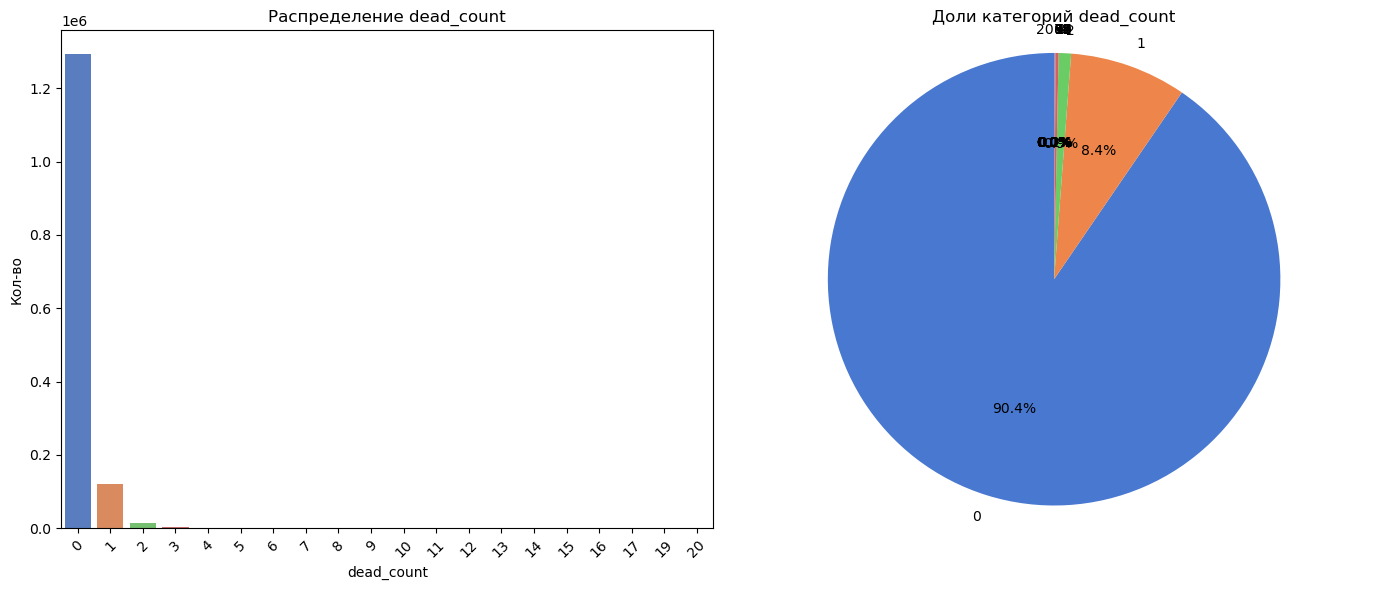

In [110]:
describe_feature(data=general_df, 
                 kind='categorical_or_discrete', 
                 feature='dead_count')

В датасете есть данные о ДТП с количеством погибших от 0 до 20 человек.

* В 90% ДТП нет погибших
* В 8.4% ДТП - 1 погибший

**Признак `injured_count` (число пострадавших)**

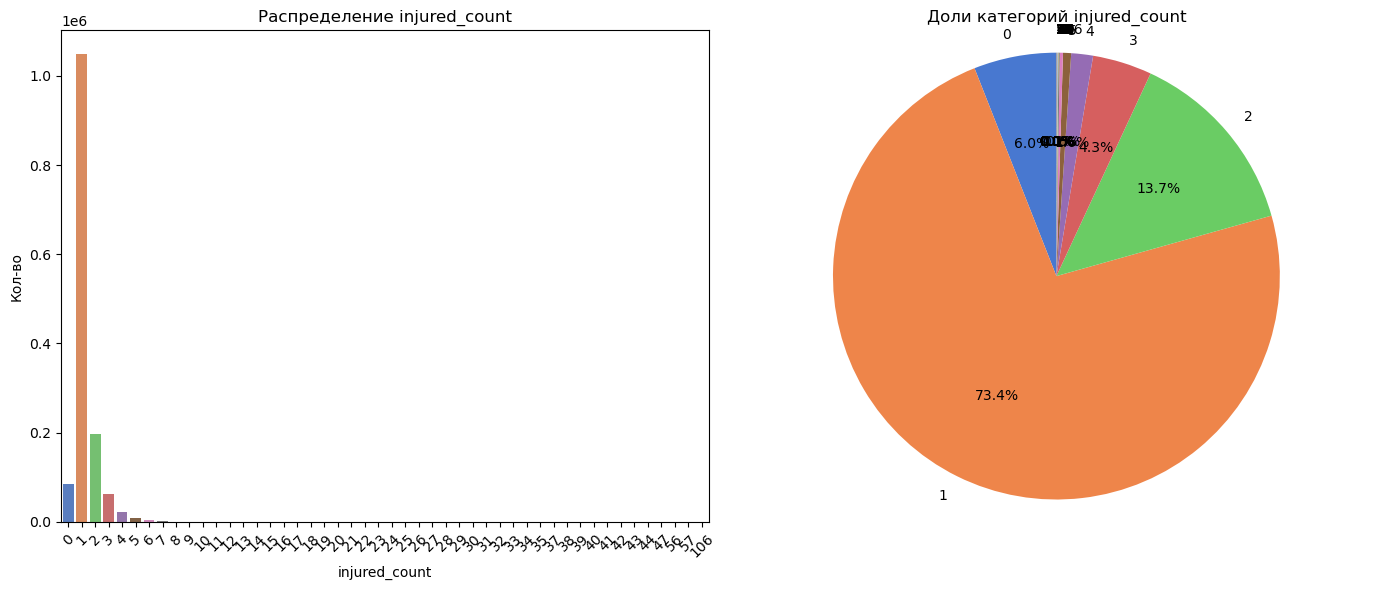

In [112]:
describe_feature(data=general_df, 
                 kind='categorical_or_discrete', 
                 feature='injured_count')

* Количество пострадавших в ДТП варьируется от 0 до 106 человек. Основная часть случаев находится в диапозоне от 0 до 5 человек.
* Чаще всего в результате ДТП оказывается пострадавшим 1 человек - 73% случаев. На втором месте по доли случаев - 2 пострадавших (около 14%)
* в 6% случаев в результате ДТП не оказывается пострадавших

**Признак `participants_count` (число участников)**

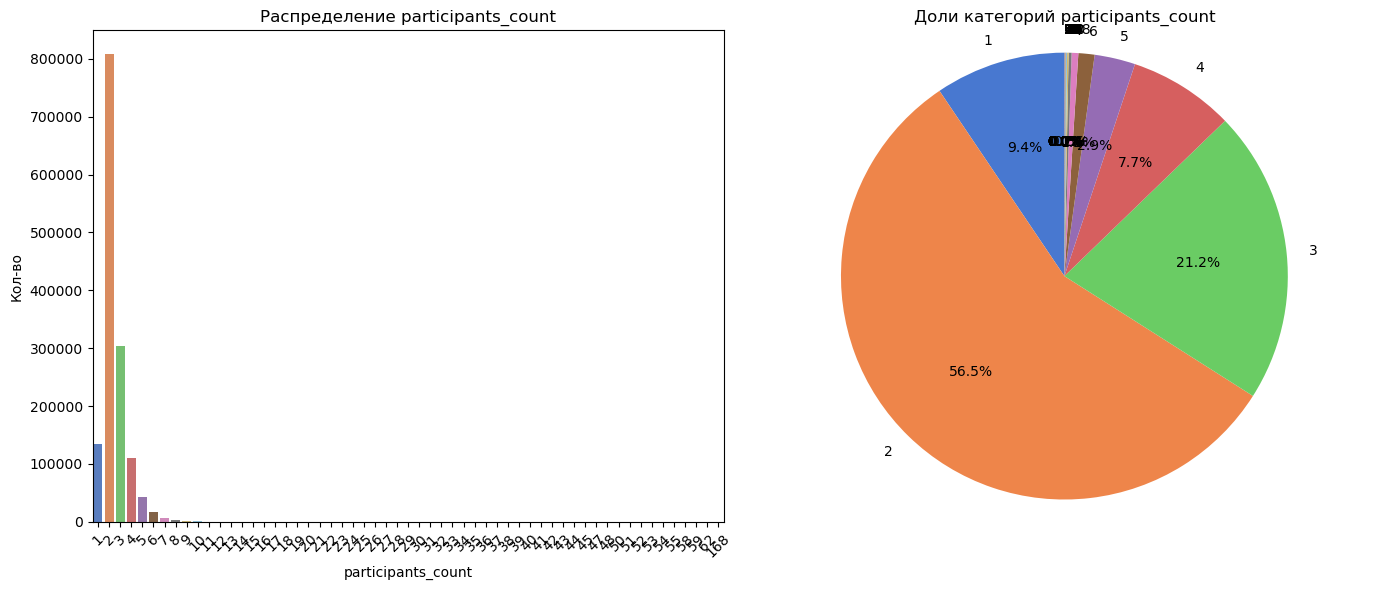

In [113]:
describe_feature(data=general_df, 
                 kind='categorical_or_discrete', 
                 feature='participants_count')

* Количество участников ДТП варьируется от 1 до 168 человек. Основная часть случаев находится в диапозоне от 1 до 6 человек.
* Чаще всего в ДТП 2 участника - 57% случаев. На втором месте по доли случаев - 3 участника (21%)
* в 9% случаев в ДТП 1 участник

**Признак `year` (год ДТП)**

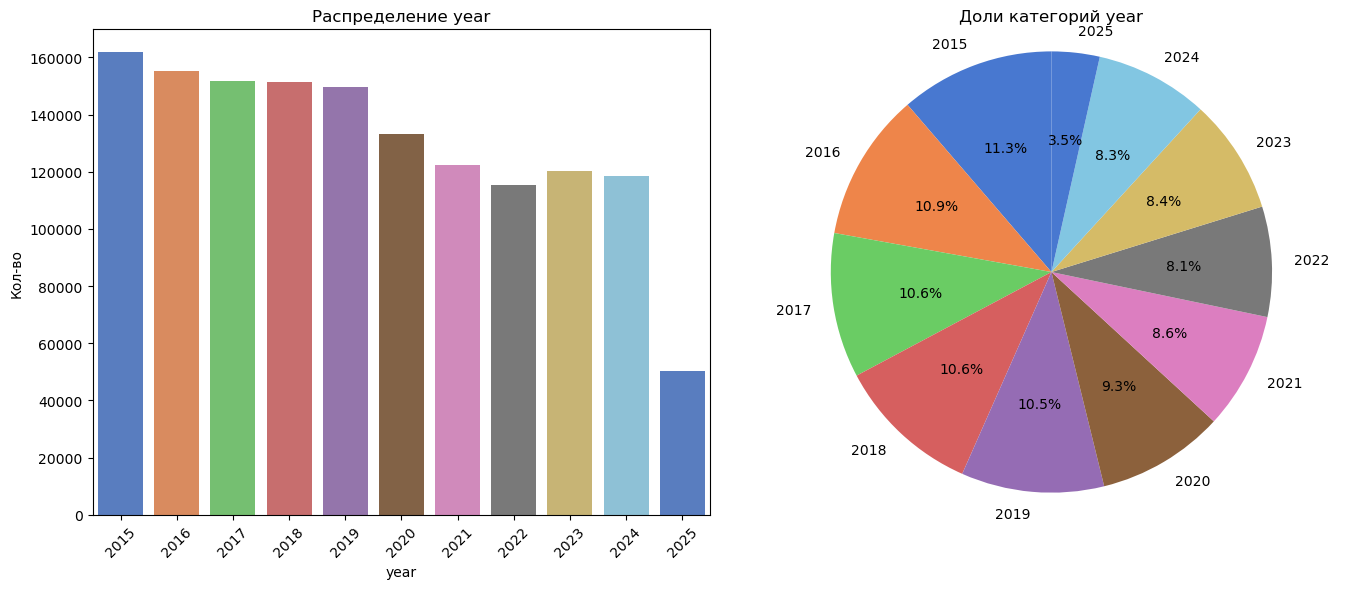

In [114]:
describe_feature(data=general_df, 
                 kind='categorical_or_discrete', 
                 feature='year')

* В датасете представлены данные с 2015 по 2025 г. 2025 - неполный.
* Видна динамика снижения абсолютного количества ДТП, если брать статистику за полные года, то минимальное количество ДТП было в 2022 г.

**Признак `month` (месяц ДТП)**

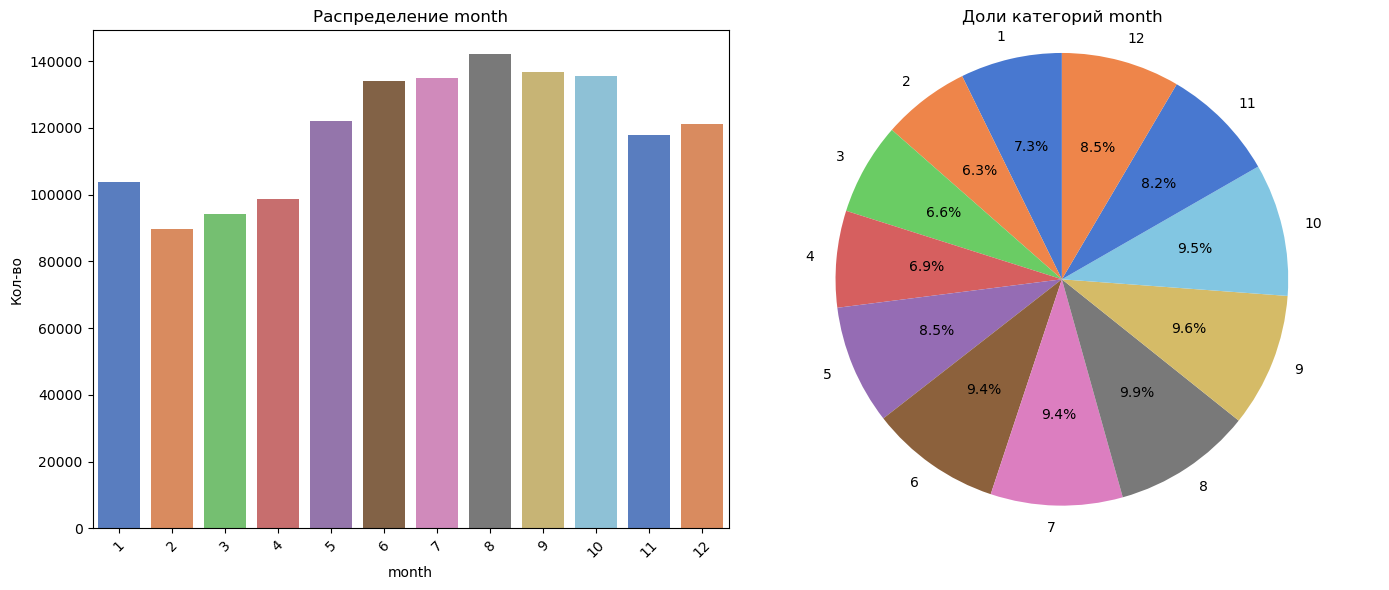

In [115]:
describe_feature(data=general_df, 
                 kind='categorical_or_discrete', 
                 feature='month')

* С мая по октябрь количество ДТП выше чем в другие месяца
* В августе происходит больше всего ДТП.
* Самые "спокойные" месяца - февраль, март, апрель

**Признак `day` (день месяца фиксации ДТП)**

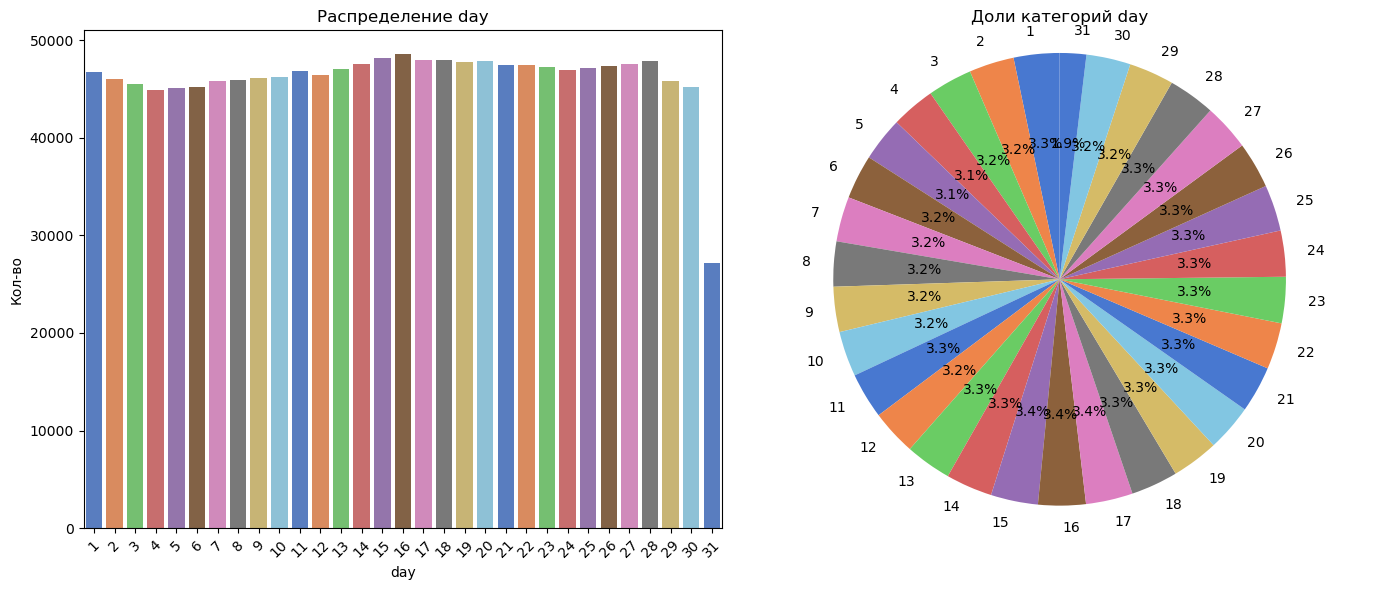

In [116]:
describe_feature(data=general_df, 
                 kind='categorical_or_discrete', 
                 feature='day')

* По количеству ДТП в разбивке по дням месяца каких то значимых закономерностей не наблюдается, количество ДТП по дням распределено достаточно равномерно, за исключением 31-го числа (так как не в каждом месяце есть этот день)

**Признак `hour` (час суток фиксации ДТП)**

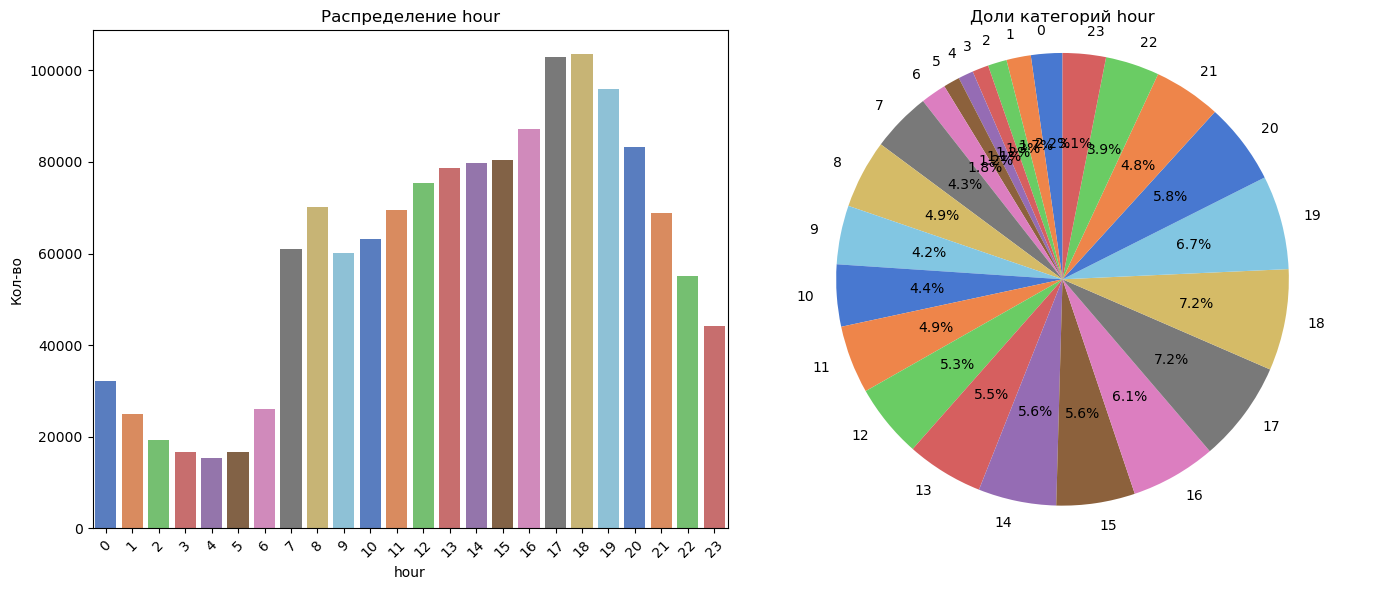

In [117]:
describe_feature(data=general_df, 
                 kind='categorical_or_discrete', 
                 feature='hour')

* В течение дня можно выделить следующие периоды по количеству фиксируемых ДТП:
    * 0-4 часа - Количество ДТП снижается
    * 5-6 часов - начинается рост кол-ва ДТП, видимо за счет того, что люди начинают выезжать на работу (например у кого рабочая смена начинается в 7)
    * 7-8 часов - резкий рост количества ДТП - время когда в основом все люди выезжают на работу / учебу
    * 9-16 часов - после локального пика количества ДТП в 8 часов происходит небольшое снижение количества фиксируемых случаев, и начиная с 9 до 16 часов плавно растет.
    * 17-18 часов - резкий рост относительно 16 часов, пиковое время по количеству фиксируемых ДТП в течение дня. В это время в основном заканчивается работа / учеба - люди выезжают домой или по другим делам. К вечеру накапливается усталость, притупляется внимание, возможно этим можно объяснить пиковые значения количества фиксируемых ДТП.
    * 19-23 часа - количество фиксируемых ДТП быстро снижается, люди добираются до дома, машин становится меньше.
    * Наименьшее количество случаев ДТП - в 4 часа утра.

**Признак `dark_light_on` (ДТП в темное время суток, освещение включено)**

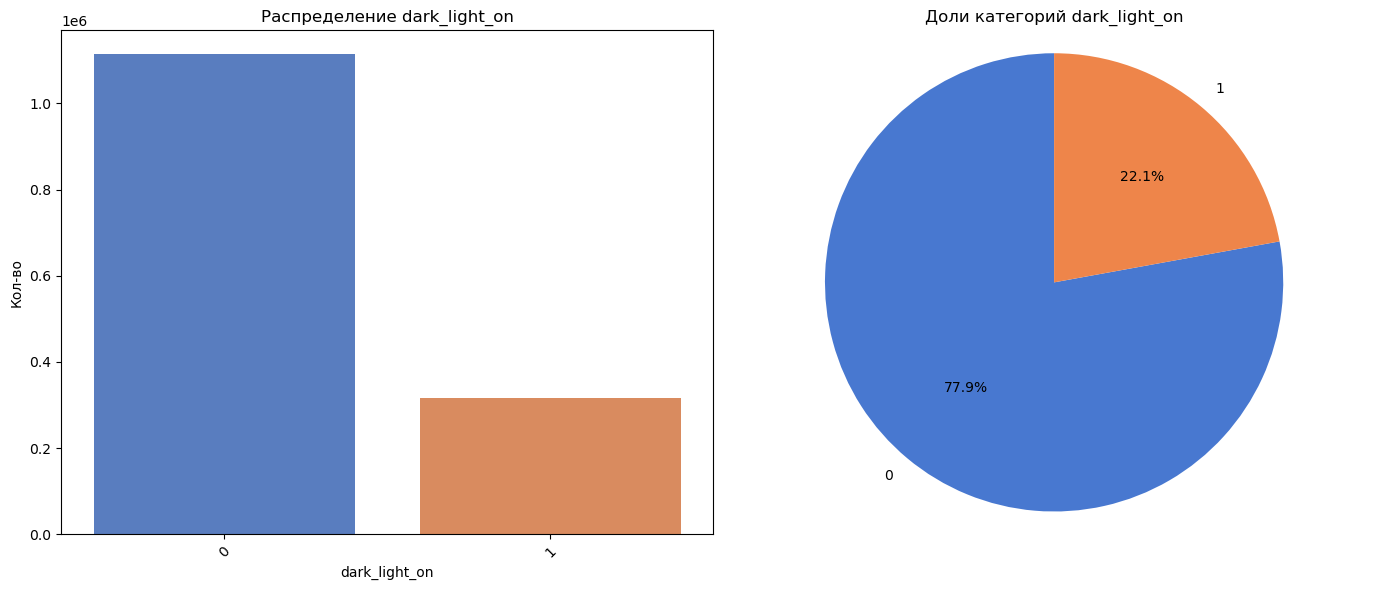

In [118]:
describe_feature(data=general_df, 
                 kind='categorical_or_discrete', 
                 feature='dark_light_on')

* 22% ДТП происходит в темное время суток с включенным освещением

**Признак `light_day` (ДТП в светлое время суток)**

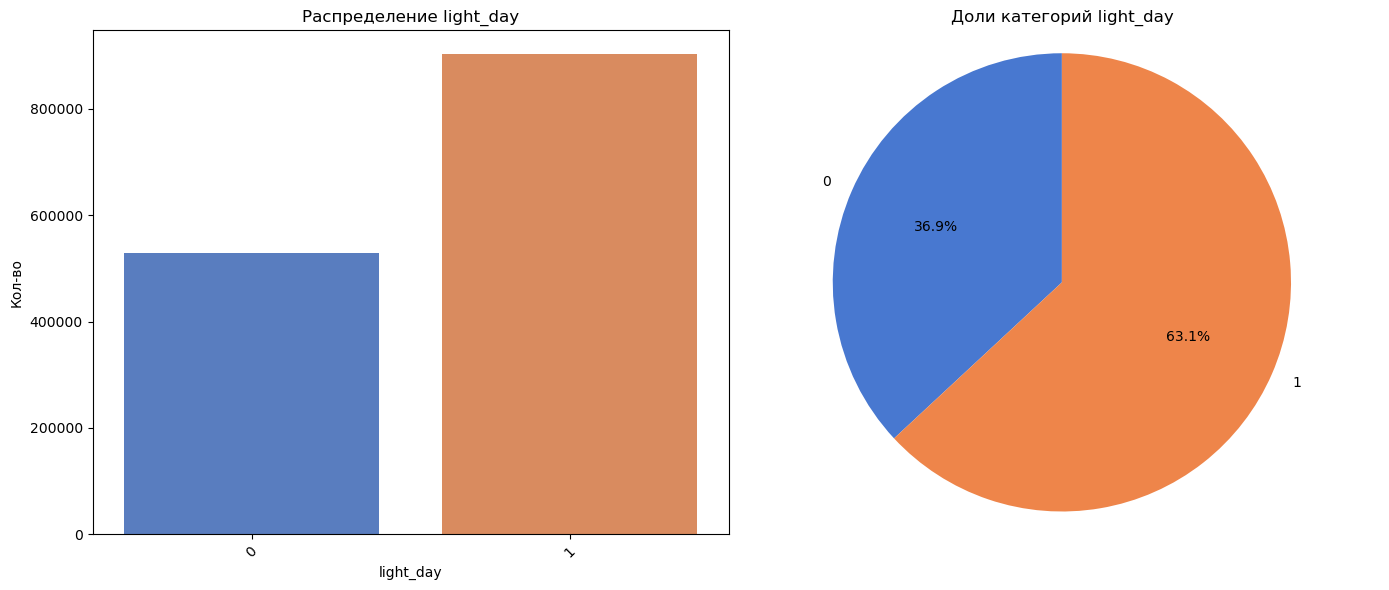

In [119]:
describe_feature(data=general_df, 
                 kind='categorical_or_discrete', 
                 feature='light_day')

* Данный признак частично коррелирует с разбивкой ДТП по часам. 63% ДТП происходят в светлое время суток

**Признак `dark_no_light` (В темное время суток, освещение отсутствует)**

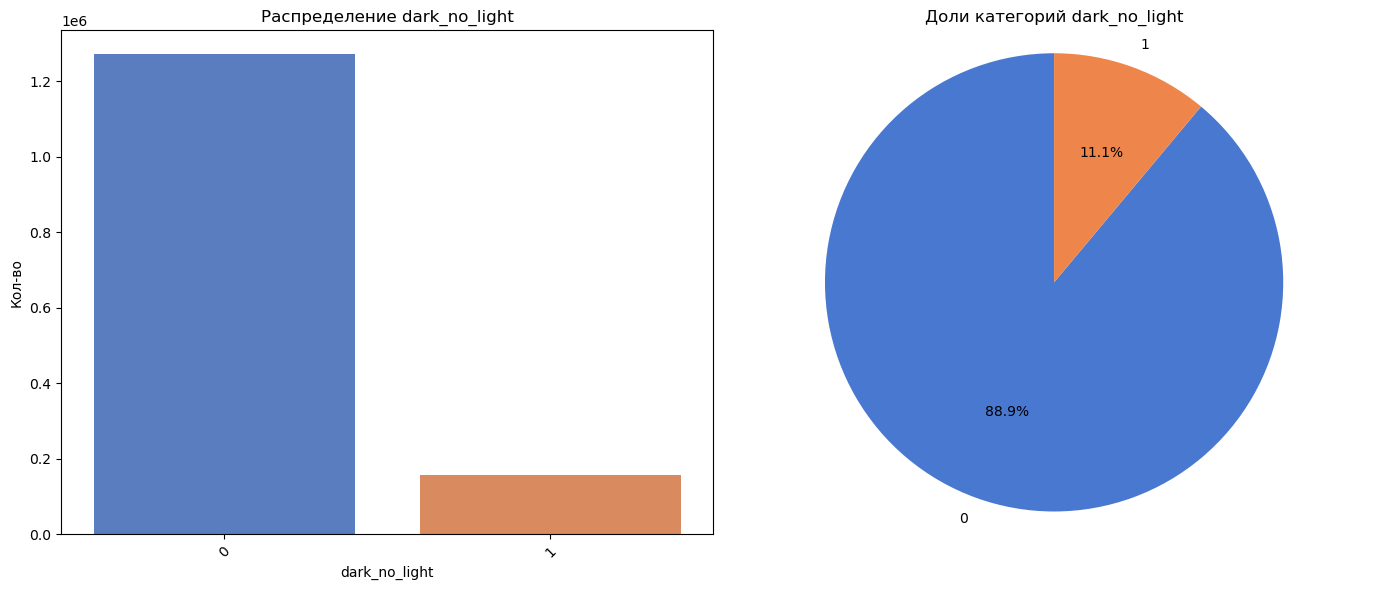

In [120]:
describe_feature(data=general_df, 
                 kind='categorical_or_discrete', 
                 feature='dark_no_light')

* 11% ДТП связано с темным временем суток и отсутствующим освещением.

**Признак `crossroads` (перекресток)**

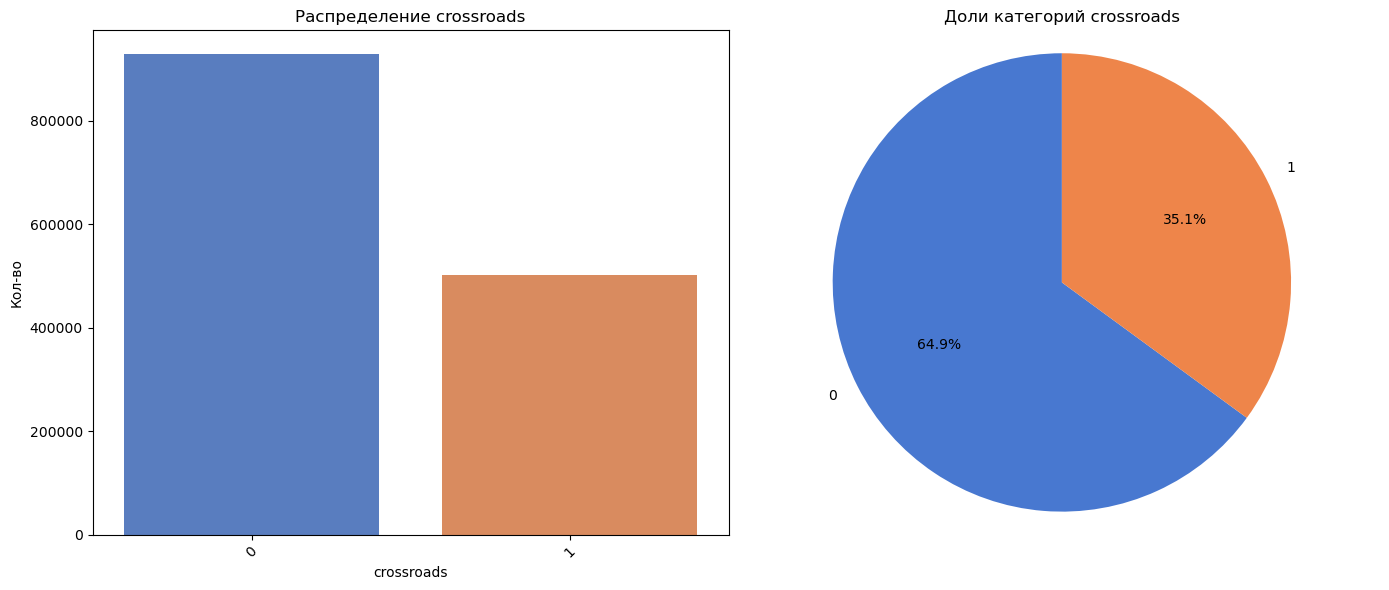

In [121]:
describe_feature(data=general_df, 
                 kind='categorical_or_discrete', 
                 feature='crossroads')

* Перекресток - место повышенной опасности, 35% ДТП происходит на перекрестке или рядом с ним.

**Признак `pedestrian_crossing` (пешеходный переход)**

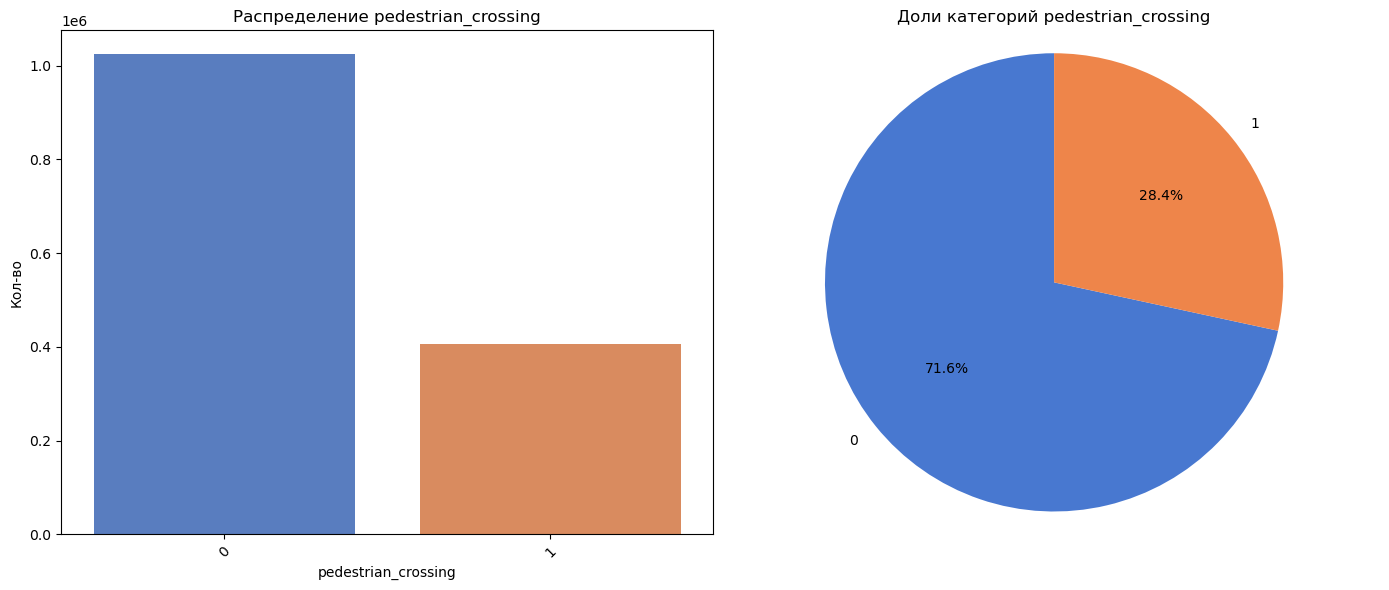

In [122]:
describe_feature(data=general_df, 
                 kind='categorical_or_discrete', 
                 feature='pedestrian_crossing')

* 28% ДТП связано с пешеходными переходами.

**Признак `regulated` (наличие регулирования)**

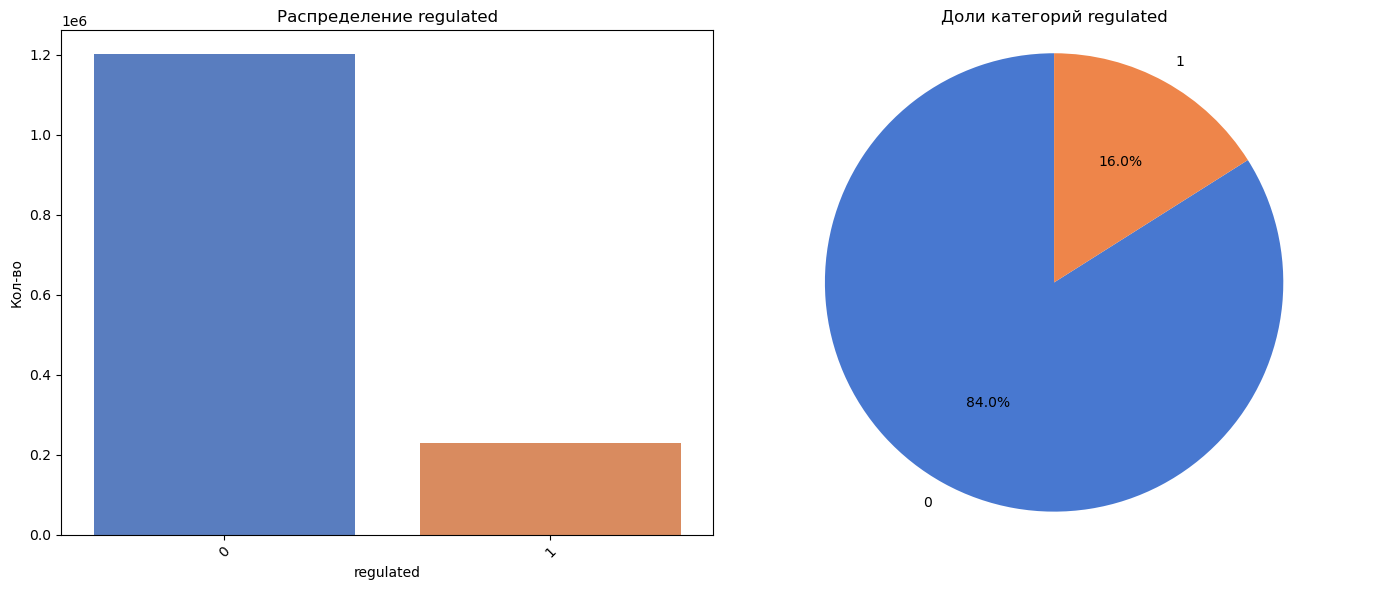

In [123]:
describe_feature(data=general_df, 
                 kind='categorical_or_discrete', 
                 feature='regulated')

* 84% ДТП происходит на нерегулируемых участках дорог, и только 16% - на регулируемых

**Признак `is_clear` (ясная погода)**

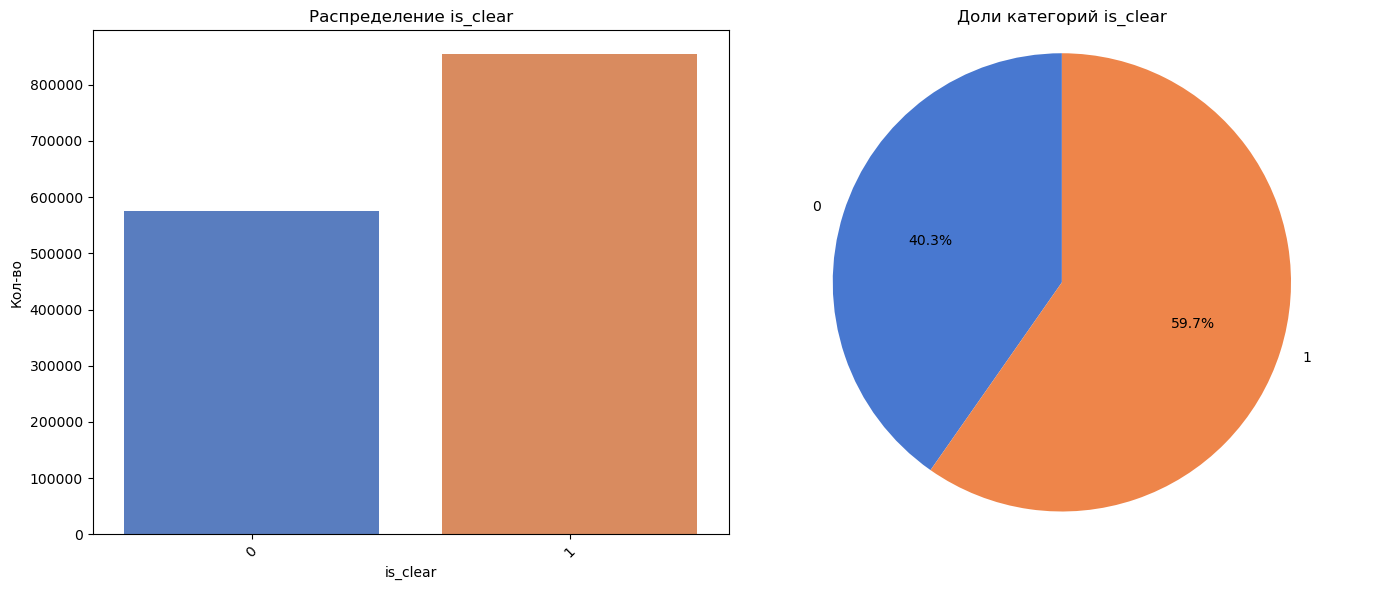

In [124]:
describe_feature(data=general_df, 
                 kind='categorical_or_discrete', 
                 feature='is_clear')

* Почти 60% ДТП происходит в ясную погоду

**Признак `is_rain` (дождь)**

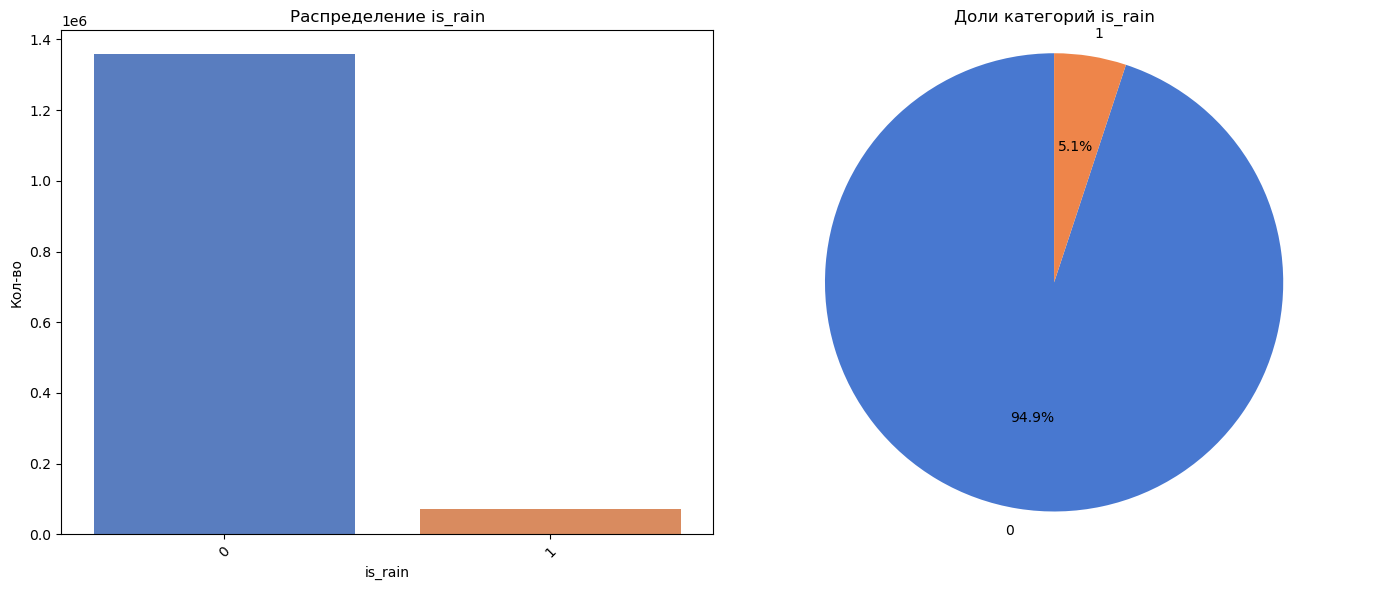

In [125]:
describe_feature(data=general_df, 
                 kind='categorical_or_discrete', 
                 feature='is_rain')

* Только 5% ДТП связано с дождивой погодой

**Признак `is_snowfall` (снегопад)**

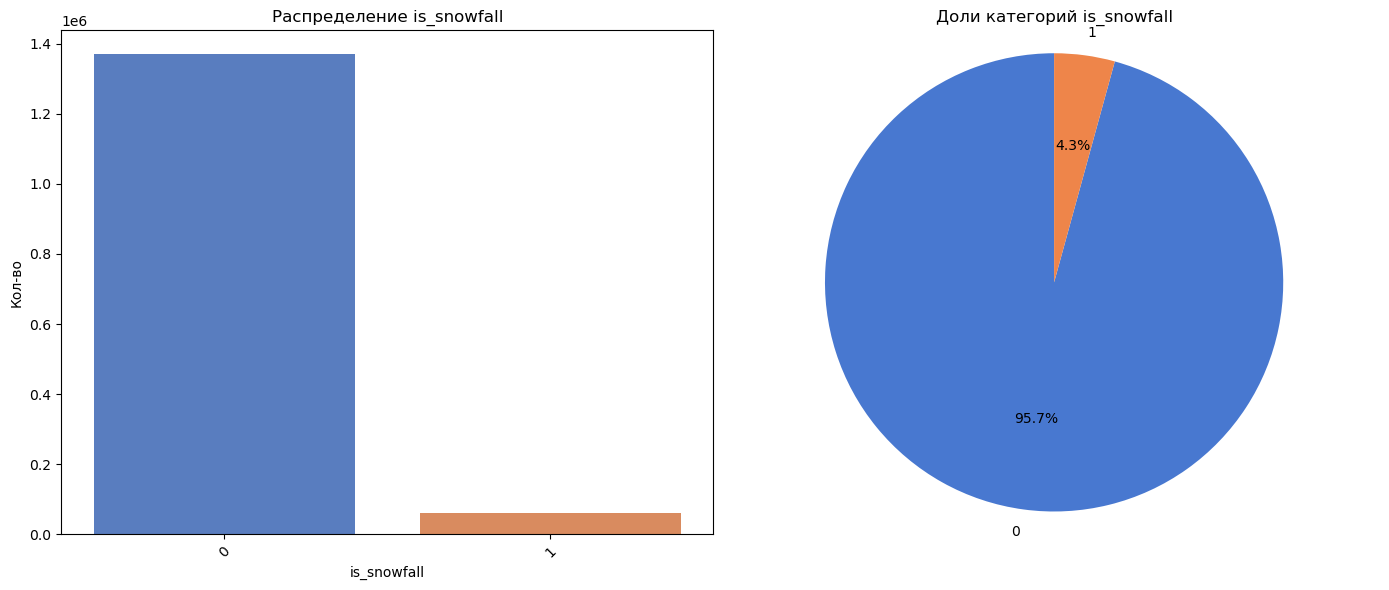

In [126]:
describe_feature(data=general_df, 
                 kind='categorical_or_discrete', 
                 feature='is_snowfall')

* Менее 5% ДТП связано со снегопадом, можно считать данный признак несущественным.

**Признак `is_cloudy` (пасмурная погода)**

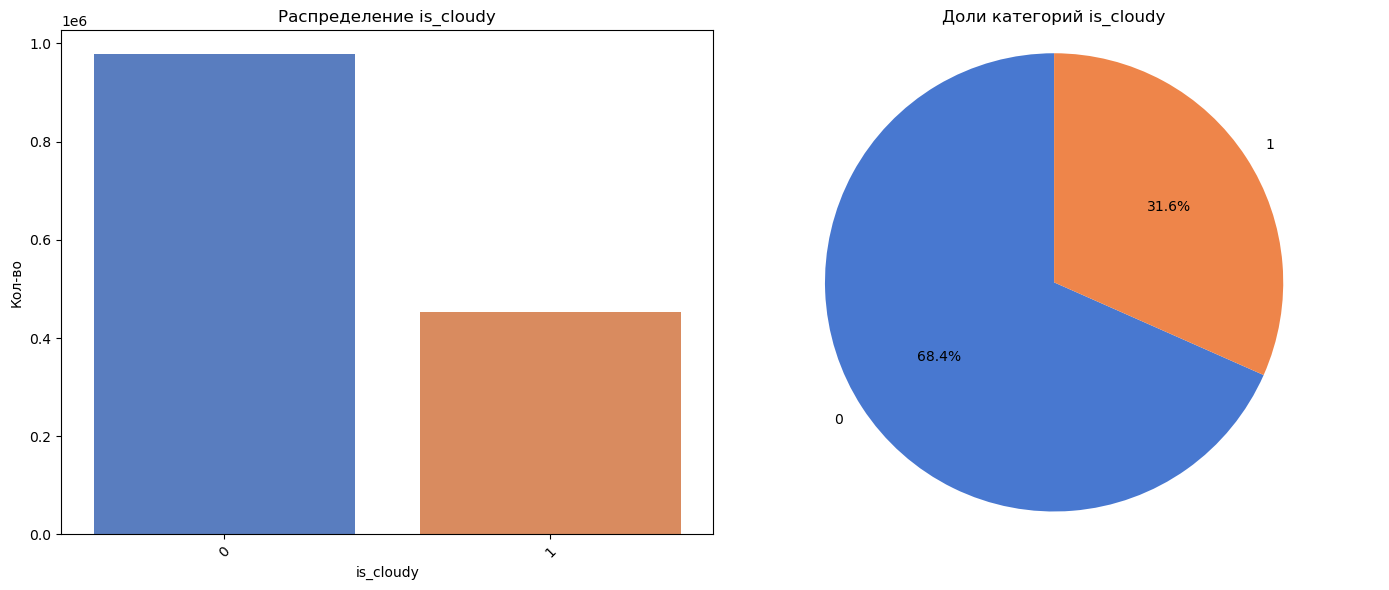

In [127]:
describe_feature(data=general_df, 
                 kind='categorical_or_discrete', 
                 feature='is_cloudy')

* Около 32% ДТП происходит в пасмурную погоду

**Признак `is_collision_with_human` (столкновение с человеком)**

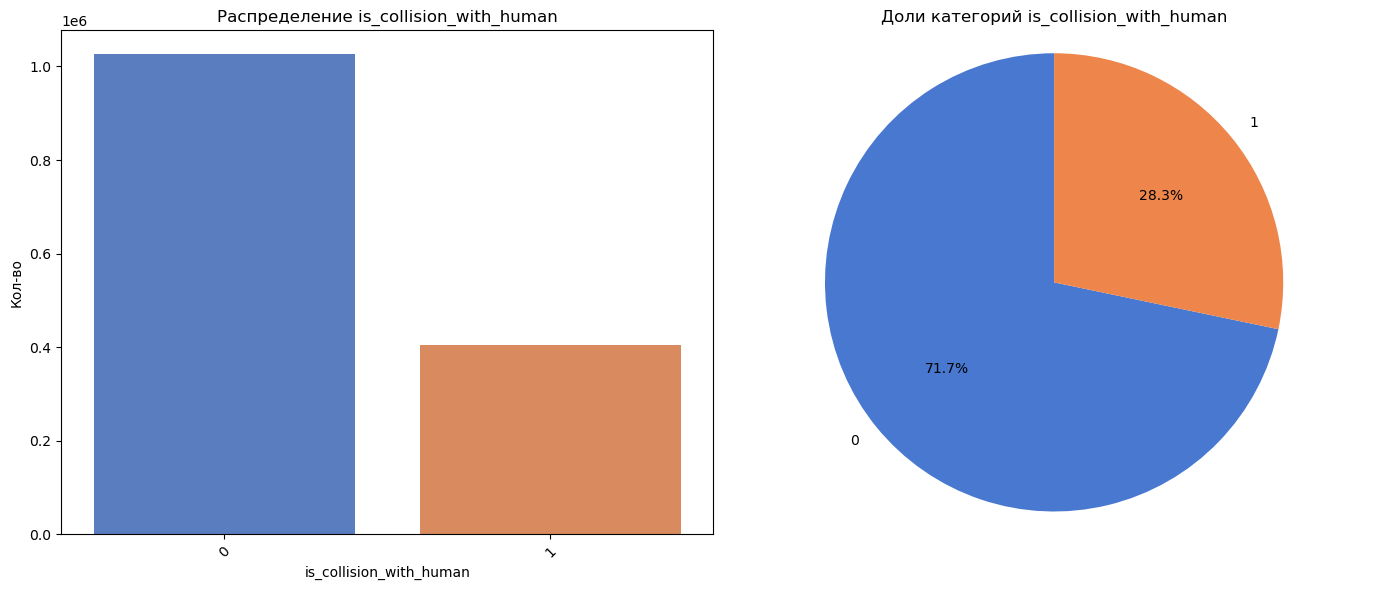

In [128]:
describe_feature(data=general_df, 
                 kind='categorical_or_discrete', 
                 feature='is_collision_with_human')

* 28% ДТП связано со столкновением с человеком

**Признак `is_collision_with_cyclist` (столкновение с велосипедистом)**

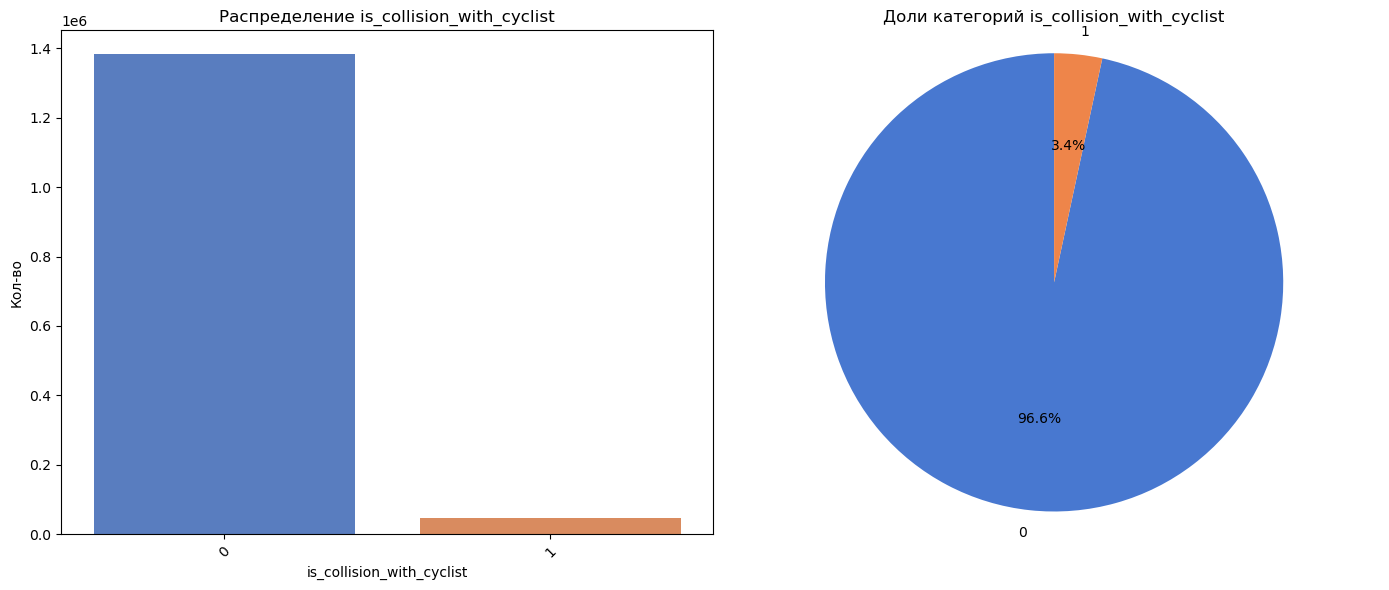

In [129]:
describe_feature(data=general_df, 
                 kind='categorical_or_discrete', 
                 feature='is_collision_with_cyclist')

* Менее 4% ДТП связано со столкновением с велосипедистом

**Признак `ice_troubles` (обледение дорожного покрытия)**

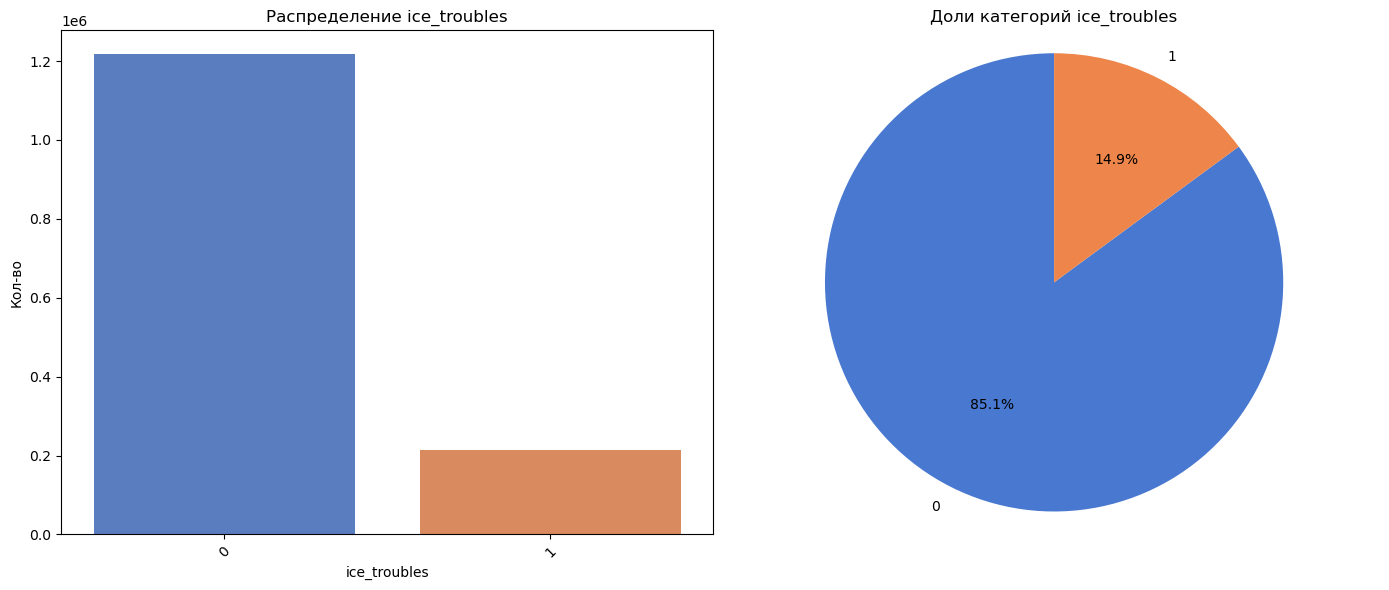

In [130]:
describe_feature(data=general_df, 
                 kind='categorical_or_discrete', 
                 feature='ice_troubles')

* Почти 15% ДТП связано с проблемами обледенения дорожного покрытия (гололед или снежный накат)

**Признак `participant_biker` (участник ДТП - мотоциклист)**

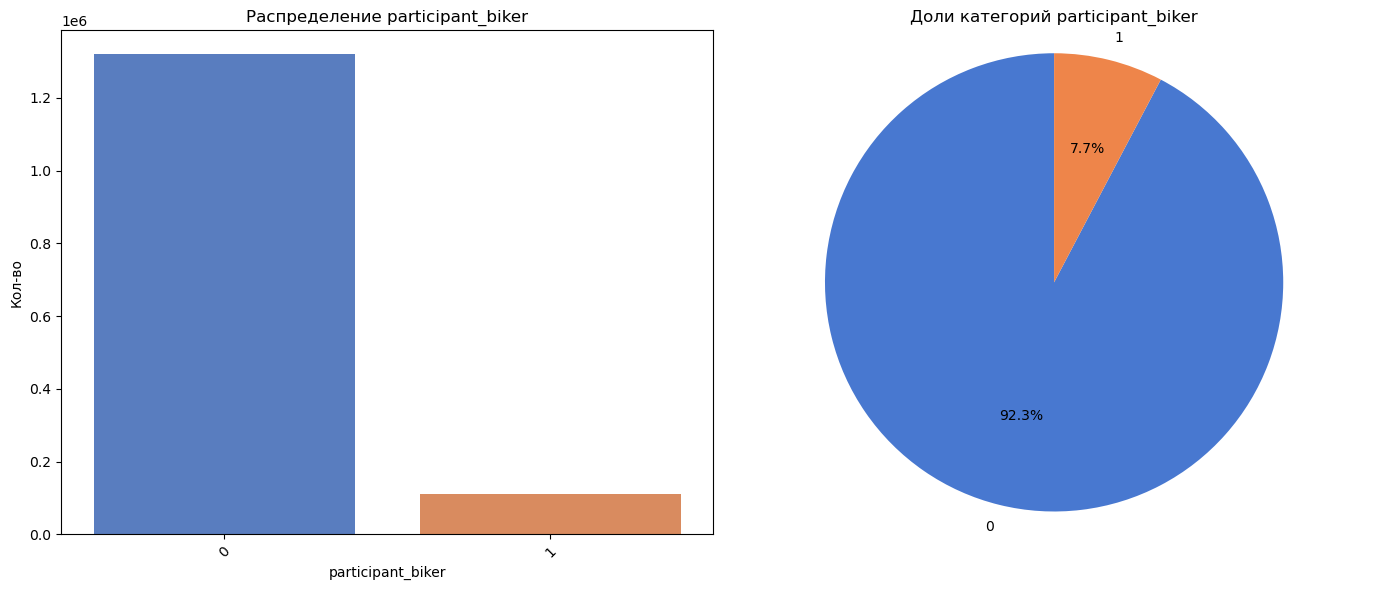

In [131]:
describe_feature(data=general_df, 
                 kind='categorical_or_discrete', 
                 feature='participant_biker')

* В почти 8% ДТП учавствуют мотоциклисты

**Признак `participant_pedestrian` (участник ДТП - пешеход)**

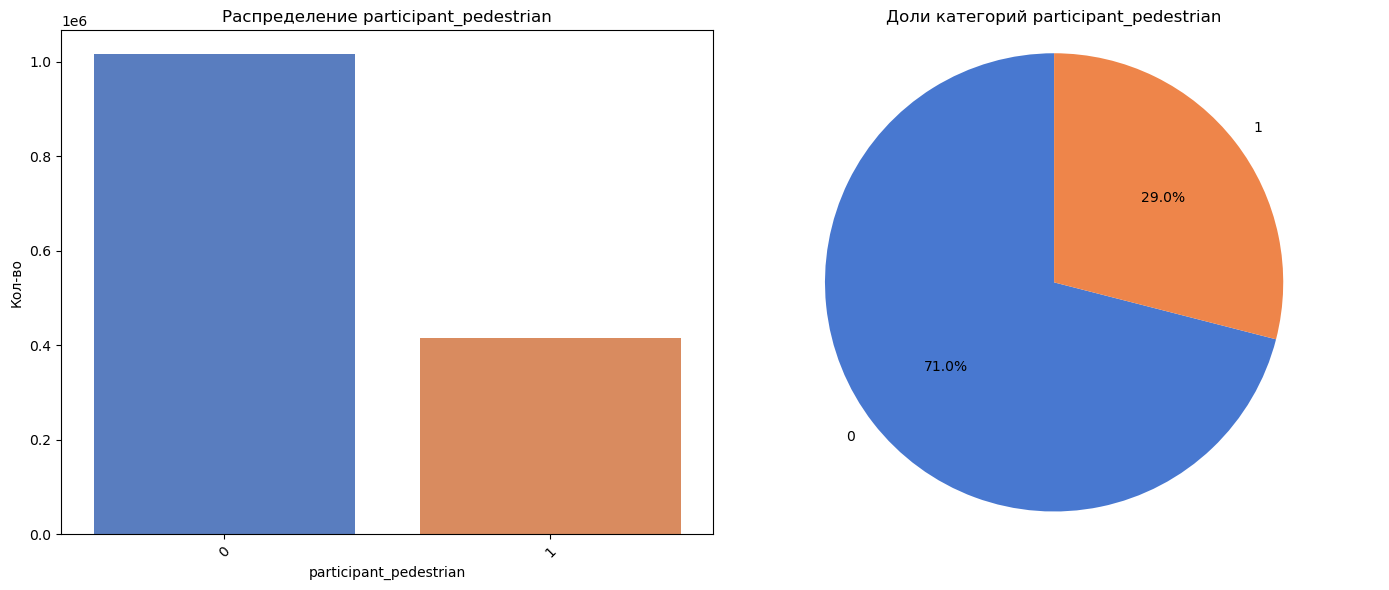

In [132]:
describe_feature(data=general_df, 
                 kind='categorical_or_discrete', 
                 feature='participant_pedestrian')

* В 29% ДТП учавствуют пешеходы

**Признак `participant_cyclist` (участник ДТП - велосипедист)**

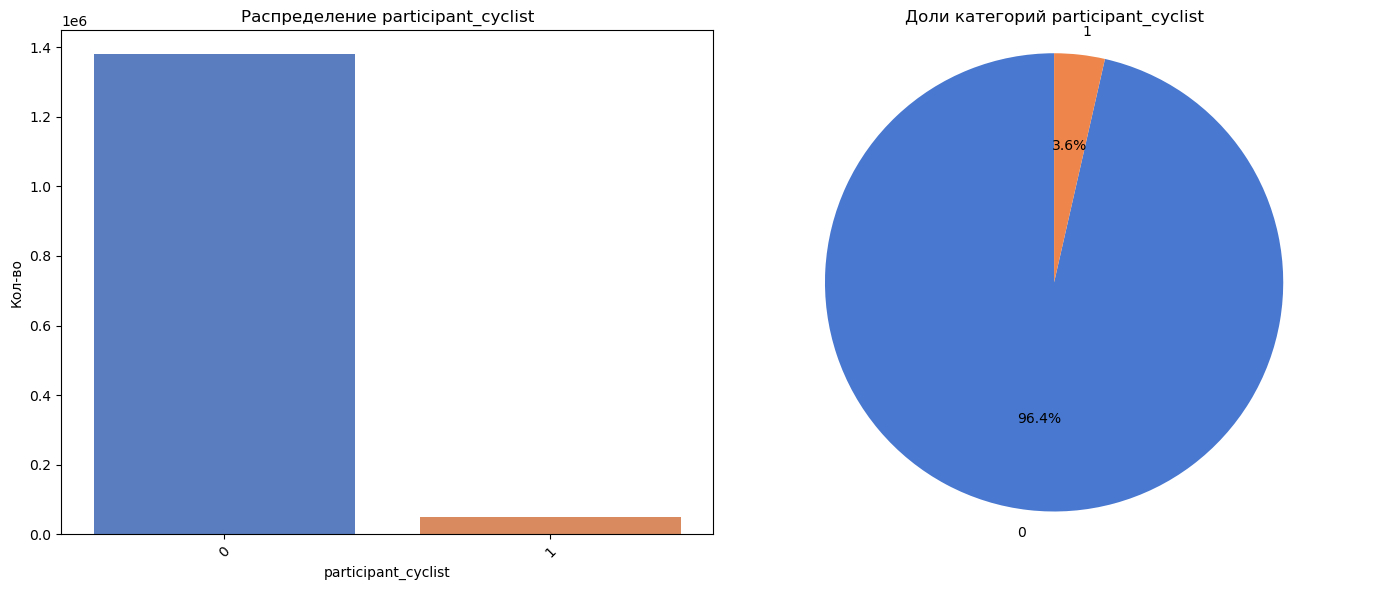

In [133]:
describe_feature(data=general_df, 
                 kind='categorical_or_discrete', 
                 feature='participant_cyclist')

* Менее чем в 4% ДТП участвуют велосипедисты

**Признак `severity` (тяжесть последствий)**

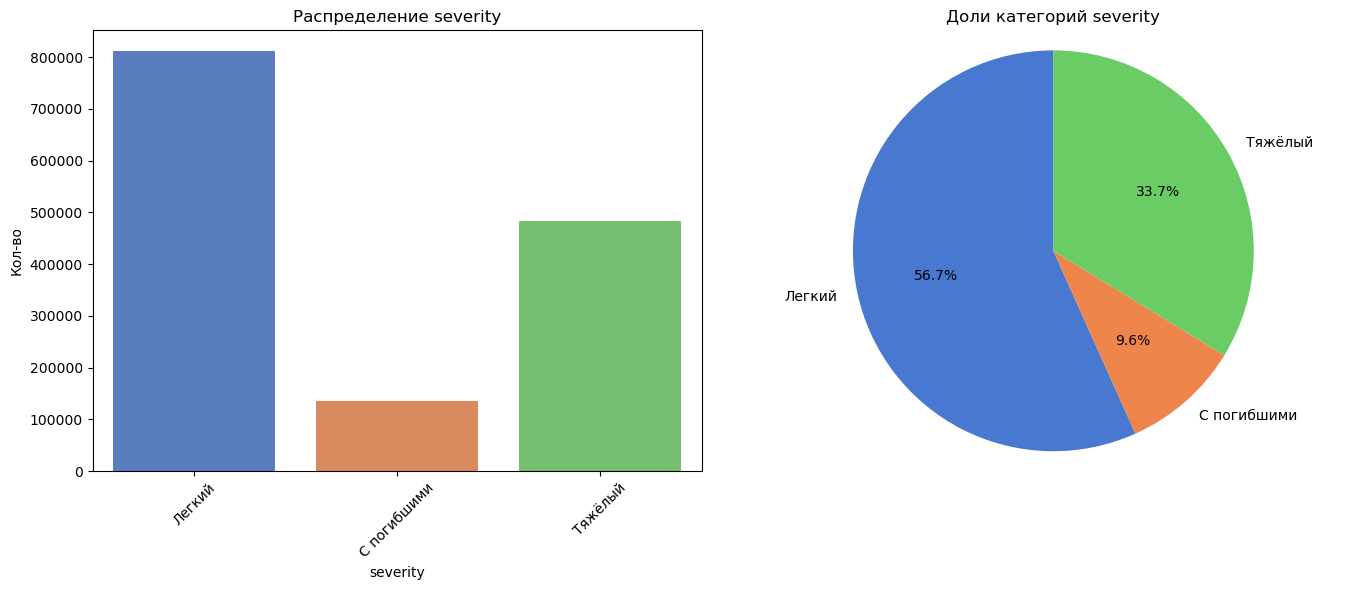

In [134]:
describe_feature(data=general_df, 
                 kind='categorical_or_discrete', 
                 feature='severity')

* 57% ДТП имеют лёгкую тяжесть / последствия для здоровья, около 34% - тяжелые случаи, а чуть менее 10% ДТП заканчиваются летальным исходом.

Выгрузим получившийся датасет для дальнейшей загрузки в базу данных PostgreSQL:

In [ ]:
#general_df.to_csv('dtp_general_dataset.csv', index=False)

#### 3.1.2. Выводы по исследовательскому анализу обобщенных данных о ДТП

**Описательная статистика данных**

* **Количество погибших (`dead_count`)**
    * В датасете есть данные о ДТП с количеством погибших от 0 до 20 человек.
    * В 90% ДТП нет погибших
    * В 8.4% ДТП - 1 погибший


* **Количество пострадавших (`injured_count`)**
    * Количество пострадавших в ДТП варьируется от 0 до 106 человек. Основная часть случаев находится в диапозоне от 0 до 5 человек.
    * Чаще всего в результате ДТП оказывается пострадавшим 1 человек - 73% случаев. На втором месте по доли случаев - 2 пострадавших (около 14%)
    * в 6% случаев в результате ДТП не оказывается пострадавших


* **Количество участников (`participants_count`)**
    * Количество участников ДТП варьируется от 1 до 168 человек. Основная часть случаев находится в диапозоне от 1 до 6 человек.
    * Чаще всего в ДТП 2 участника - 57% случаев. На втором месте по доли случаев - 3 участника (21%)
    * в 9% случаев в ДТП 1 участник


* **Год ДТП (`year`)**
    * В датасете представлены данные с 2015 по 2025 г. 2025 - неполный.
    * Видна динамика снижения абсолютного количества ДТП, если брать статистику за полные года, то минимальное количество ДТП было в 2022 г.

* **Месяц ДТП (`month`)**
    * С мая по октябрь количество ДТП выше чем в другие месяца
    * В августе происходит больше всего ДТП.
    * Самые "спокойные" месяца - февраль, март, апрель


* **День ДТП (`day`)**
    * По количеству ДТП в разбивке по дням месяца каких то значимых закономерностей не наблюдается, количество ДТП по дням распределено достаточно равномерно, за исключением 31-го числа (так как не в каждом месяце есть этот день)


* **Час ДТП (`hour`)**
    * В течение дня можно выделить следующие периоды по количеству фиксируемых ДТП:
        * 0-4 часа - Количество ДТП снижается
        * 5-6 часов - начинается рост кол-ва ДТП, видимо за счет того, что люди начинают выезжать на работу (например у кого рабочая смена начинается в 7)
        * 7-8 часов - резкий рост количества ДТП - время когда в основом все люди выезжают на работу / учебу
        * 9-16 часов - после локального пика количества ДТП в 8 часов происходит небольшое снижение количества фиксируемых случаев, и начиная с 9 до 16 часов плавно растет.
        * 17-18 часов - резкий рост относительно 16 часов, пиковое время по количеству фиксируемых ДТП в течение дня. В это время в основном заканчивается работа / учеба - люди выезжают домой или по другим делам. К вечеру накапливается усталость, притупляется внимание, возможно этим можно объяснить пиковые значения количества фиксируемых ДТП.
        * 19-23 часа - количество фиксируемых ДТП быстро снижается, люди добираются до дома, машин становится меньше.
        * Наименьшее количество случаев ДТП - в 4 часа утра.


* **ДТП в светлое время суток (`light_day`)**
    * Данный признак частично коррелирует с разбивкой ДТП по часам. 63% ДТП происходят в светлое время суток

 
* **ДТП В темное время суток, освещение включено (`dark_light_on`)**
    * 22% ДТП происходит в темное время суток с включенным освещением

 
* **ДТП в темное время суток, освещение отсутствует (`dark_no_light`)**
    * 11% ДТП связано с темным временем суток и отсутствующим освещением.
 
* **Перекресток (`crossroads`)**
    * Перекресток - место повышенной опасности, 35% ДТП происходит на перекрестке или рядом с ним.

 
* **Пешеходный переход (`pedestrian_crossing`)**
    * 28% ДТП связано с пешеходными переходами.


* **Регулируемый участок (`regulated`)**
    * 84% ДТП происходит на нерегулируемых участках дорог, и только 16% - на регулируемых.


* **Ясная погода (`is_clear`)**
    * Почти 60% ДТП происходит в ясную погоду

* **Дождь (`is_rain`)**
    * Только 5% ДТП связано с дождивой погодой

* **Снегопад (`is_snowfall`)**
    * Менее 5% ДТП связано со снегопадом, можно считать данный признак несущественным.


* **Пасмурная погода (`is_cloudy`)**
    * Около 32% ДТП происходит в пасмурную погоду.


* **Столкновение с человеком (`is_collision_with_human`)**
    * 28% ДТП связано со столкновением с человеком

 
* **Столкновение с велосипедистом (`is_collision_with_cyclist`)**
    * Менее 4% ДТП связано со столкновением с велосипедистом


* **Обледение дорожного покрытия (`ice_troubles`)**
    * Почти 15% ДТП связано с проблемами обледенения дорожного покрытия (гололед или снежный накат)


* **Участник ДТП - мотоциклист (`participant_biker`)** 
    * В почти 8% ДТП учавствуют мотоциклисты

 
* **Участник ДТП - пешеход (`participant_pedestrian`)** 
    * В 29% ДТП учавствуют пешеходы

 
* **Участник ДТП - велосипедист (`participant_cyclist`)**
    * Менее чем в 4% ДТП участвуют велосипедисты

* **Степень тяжести (`participant_cyclist`)**
    * 57% ДТП имеют лёгкую тяжесть / последствия для здоровья, около 34% - тяжелые случаи, а чуть менее 10% ДТП заканчиваются летальным исходом.

### 3.2 Данные о транспортных средствах

#### 3.2.1. Описательная статистика

Посмотрим описательную статистику для числовых полей:

In [136]:
vehicles_df[['year', 'age']].describe()

,year,age
count,2171923.00,2171923.00
mean,2008.52,10.91
std,7.99,7.75
min,1942.00,0.00
25%,2004.00,5.00
50%,2010.00,10.00
75%,2014.00,15.00
max,2025.00,76.00


**Год выпуска ТС (`year`)**

Для масштаба - отфильтруем ТС с годом выпуска не ранее 1980 г.

Min: 1981
Max: 2025
Среднее: 2008.64
Медиана: 2010.00
Ст. откл-е: 7.75


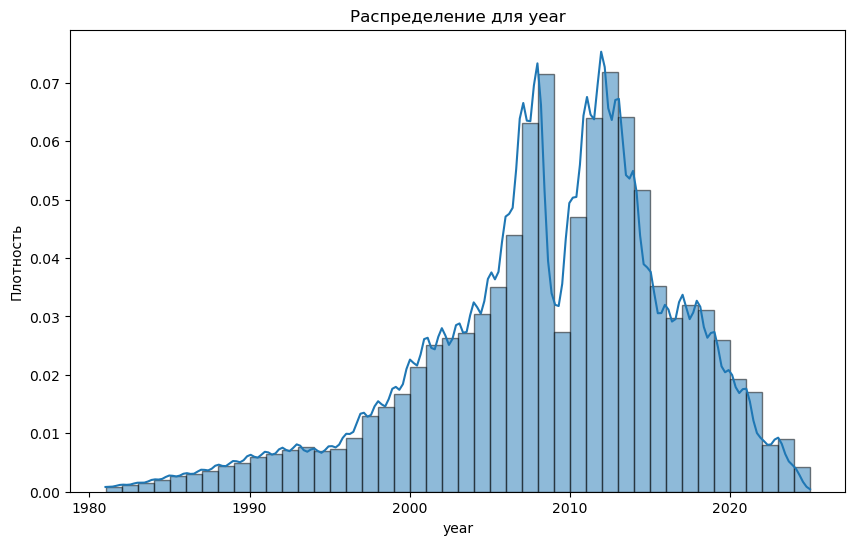

In [166]:
describe_feature(data=vehicles_df.query('year>1980'), 
                 kind='continuous', 
                 feature='year')

* Большая част автомобилей была выпущена в период с 1999 по 2021 г.

**Возраст ТС на момент ДТП (`age`)**

Для масштаба - отфильтруем ТС с годом выпуска не ранее 1980 г.

Min: 0
Max: 44
Среднее: 10.79
Медиана: 10.00
Ст. откл-е: 7.50


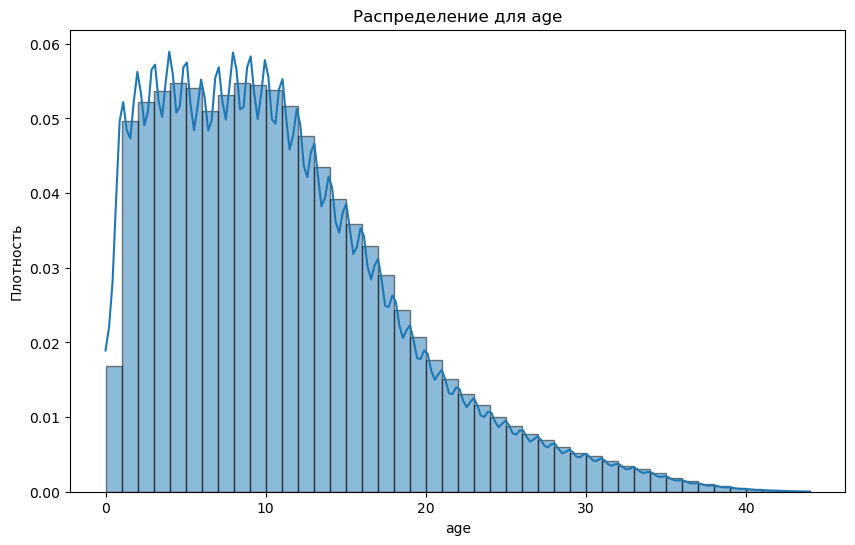

In [144]:
describe_feature(data=vehicles_df.query('year>1980'), 
                 kind='continuous', 
                 feature='age')

* Самый частый возраст ТС на момент ДТП - до 15 лет.

**Цвет ТС (`color`)**

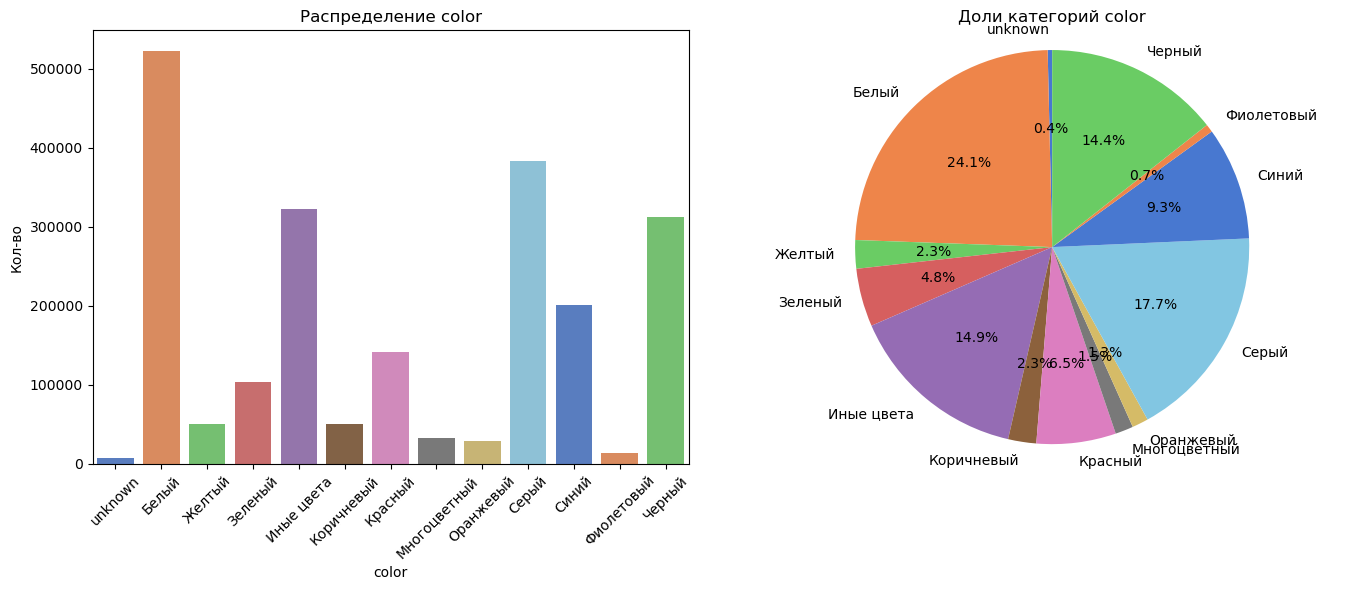

In [155]:
describe_feature(data=vehicles_df, 
                 kind='categorical_or_discrete', 
                 feature='color')

ТОП-3 цвета автомобилей попадающих в ДТП:
* Белый (24%)
* Серый (17.7%)
* Черный (14.4%)

**Бренд и модель ТС (`brand`, `model`)**

Посмотрим топ 10 брэндов ТС попадающих в ДТП:

In [156]:
vehicles_df.groupby(['brand', 'model'])[['id']].agg('count').sort_values(by='id', ascending=False).head(10)

id
brand           model                                    
ВАЗ             Granta (Гранта)                     55892
Прочие марки ТС Прочие марки и модели ТС            55809
ВАЗ             Priora                              48900
HYUNDAI         Solaris                             42393
KIA             Rio                                 41947
ВАЗ             ВАЗ 2114 и модификации              41228
                Жигули  ВАЗ-2108, 09 и модификации  40814
                Kalina                              39104
RENAULT         Logan                               38820
ВАЗ             Жигули  ВАЗ-2107 модификации        38308

* Из топ-10 автомобилей чаще всего попадающих в ДТП - 6 - автомобили марки ВАЗ (Гранта, Приора, 2114, 2108(09), Калина, 2107). Также в топ-10 попали марки наиболее часто встречающиеся в сервисах такси - Хёндэ Солярис, КИА Рио, Рено Логан.

**Категория ТС (`category`)**

In [163]:
vehicles_df.groupby(['category'])[['id']].agg('count').sort_values(by='id', ascending=False)

,id
category,
"В-класс (малый) до 3,9 м",821329
"С-класс (малый средний, компактный) до 4,3 м",380181
Прочие легковые автомобили,171902
"D-класс (средний) до 4,6 м",161505
Мотоциклы,71845
...,...
Прицепы тракторные,5
Транспортные средства для перевозки детей,3
Полуприцепы-фургоны,3


* Чаще всего в ДТП попадают автомобили B, C, D класса, мотоциклы и прочие легковые автомобили.
* Реже всего в ДТП попадают прицепы и полуприцепы

#### 3.2.1. Выводы по исследовательскому анализу данных о транспортных средствах

* Основная часть автомобилей-участников ДТП была выпущена в период с 1999 по 2021 г.
* Самый частый возраст ТС на момент ДТП - до 15 лет.
* ТОП-3 цвета автомобилей попадающих в ДТП:
    * Белый (24%)
    * Серый (17.7%)
    * Черный (14.4%)
* Из топ-10 автомобилей чаще всего попадающих в ДТП - 6 - автомобили марки ВАЗ (Гранта, Приора, 2114, 2108(09), Калина, 2107). Также в топ-10 попали марки наиболее часто встречающиеся в сервисах такси - Хёндэ Солярис, КИА Рио, Рено Логан.
* Чаще всего в ДТП попадают автомобили B, C, D класса, мотоциклы и прочие легковые автомобили.

Сохраним получившийся датасет для переноса в БД:

In [167]:
#vehicles_df.to_csv('vehicles_data.csv', index=False)

### 3.3 Данные об участниках ДТП

## 4. Проверка гипотез

## 5. Общие выводы по исследованию